# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

Loan defaults pose a significant financial risk to lending institutions. Identifying potential defaulters before issuing loans is critical for maintaining financial health, reducing losses, and ensuring responsible lending. As the lending industry becomes increasingly data-driven, leveraging historical loan and customer data for predictive insights can dramatically improve decision-making and risk assessment.

### **The objective:**

The goal is to develop a robust machine learning model that accurately predicts whether a loan applicant is likely to default. This will enable the institution to make informed lending decisions, minimize risk exposure, and optimize its credit portfolio.

### **The key questions:**

Which customer attributes are the strongest indicators of loan default risk?

What preprocessing and modeling approaches yield the most accurate and generalizable predictions?

How can we balance false positives and false negatives, especially given the business cost of missing defaulters? 

### **The problem formulation**:

This is a binary classification problem where the target variable BAD indicates whether a customer defaulted (1) or not (0).
Using historical customer and loan data, we aim to train and evaluate various machine learning models to classify new loan applicants as high or low risk, thereby supporting strategic credit decision-making.

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold          
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings


## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values

In [2]:
data = pd.read_csv("hmeq.csv")
df = data.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
print('Shape:', df.shape)
df.head() 

Shape: (5960, 13)


BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

In [5]:
df.describe()

BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85.810092     1.728675    10.138933   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   115.116702     0.000000    15.000000   
50%       0.000000     0.000000   173.466667     1.000000    20.000000   
75%       0.000000     0.000000   231.562278     2.000000    26.000000   
max      10.000000    15.000000  1168.233561    17.000000    71.000000   

           DEBTINC  
count  4693.000000  
mean     33.779915  
std       8.601746  
min       0.524499  
25%      29.140031  
50%      34.818262  
75%      39.003141  
max     203.312149

In [6]:
def check_missing_values(data):
    '''
    Prints the number of features with missing values, their percentage
    in the total dataset, and visualizes these missing values.

    ---
    ### Parameters
    data <DataFrame>: DataFrame with the data to be checked for missing values
    '''
    # Calculate the number of missing values per column and filter columns that have missing values
    count = data.isnull().sum()
    count = count[count > 0]

    # Early exit if no missing values are found
    if count.empty:
        print("No missing values found in the dataset.")
        return

    # Calculate the percentage of missing values
    percentage = (count / len(data)) * 100

    # Creating a DataFrame to display count and percentage of missing values
    result = pd.DataFrame({'Count': count, 'Percentage %': percentage.round(2)})

    # Print results
    print(f"{result.shape[0]} columns have missing values")
    print('-'*30)
    print(result)

    # Plotting the missing values
    msno.bar(data, figsize=(10, 5), fontsize=12, color="skyblue")

11 columns have missing values
------------------------------
         Count  Percentage %
MORTDUE    518          8.69
VALUE      112          1.88
REASON     252          4.23
JOB        279          4.68
YOJ        515          8.64
DEROG      708         11.88
DELINQ     580          9.73
CLAGE      308          5.17
NINQ       510          8.56
CLNO       222          3.72
DEBTINC   1267         21.26


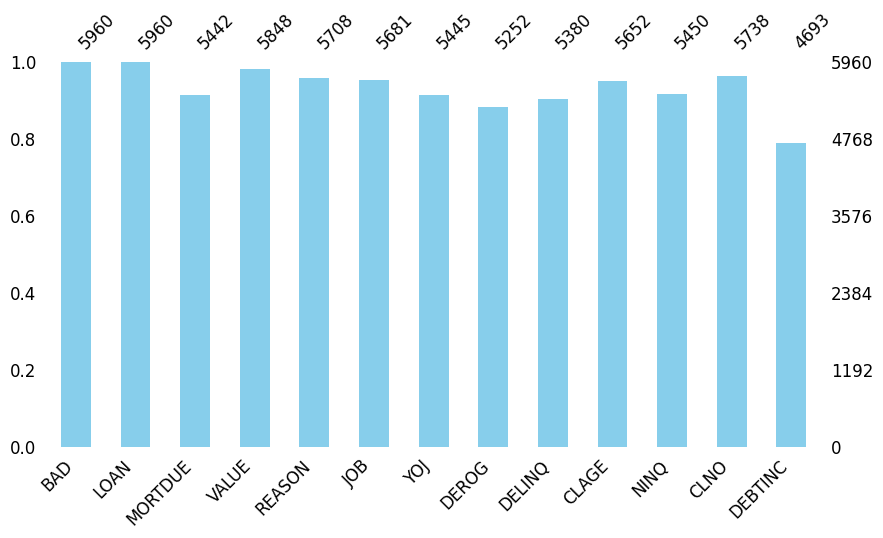

In [7]:
check_missing_values(df)

In [8]:
# Define numerical and categorical columns based on your dataset
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

cat_cols = ['REASON', 'JOB']

In [9]:
# Create a skewness summary DataFrame
skew_summary = pd.DataFrame({
    'Feature': num_cols,
    'Skewness': [df[col].skew().round(2) for col in num_cols]
}).sort_values(by='Skewness', ascending=False)

skew_summary


Feature  Skewness
4    DEROG      5.32
5   DELINQ      4.02
2    VALUE      3.05
9  DEBTINC      2.85
7     NINQ      2.62
0     LOAN      2.02
1  MORTDUE      1.81
6    CLAGE      1.34
3      YOJ      0.99
8     CLNO      0.78

All imputed features were found to be moderately to heavily skewed (skewness > 0.5), making the median a more robust choice over the mean to prevent distortion from outliers

## **Exploratory Data Analysis (EDA) and Visualization**

There are a lot of missing values, in EDA there are going to be checks if data is skewed median will be used for inputing missing values, if not mean for numeric variables. For categorical variables mode will be applied.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Univariate Analysis**


In [10]:
def histogram_boxplot(data, feature, figsize=(12, 6), kde=False, bins=30):
    """
    Combined boxplot and histogram for univariate analysis.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The dataset to plot from.
    feature : str
        Column name to plot.
    figsize : tuple
        Size of the entire figure.
    kde : bool
        Whether to include a Kernel Density Estimate in the histogram.
    bins : int or None
        Number of histogram bins.
    """
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize
    )
    
    # Boxplot (top)
    sns.boxplot(
        data=data, x=feature, ax=ax_box, showmeans=True, color="skyblue"
    )
    ax_box.set(xlabel="")
    
    # Histogram (bottom)
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist, bins=bins, color="steelblue"
    )
    ax_hist.axvline(data[feature].mean(), color="green", linestyle="--", label="Mean")
    ax_hist.axvline(data[feature].median(), color="black", linestyle="-", label="Median")
    ax_hist.legend()
    
    plt.suptitle(f"Boxplot & Histogram for {feature}", fontsize=14)
    plt.tight_layout()
    plt.show()

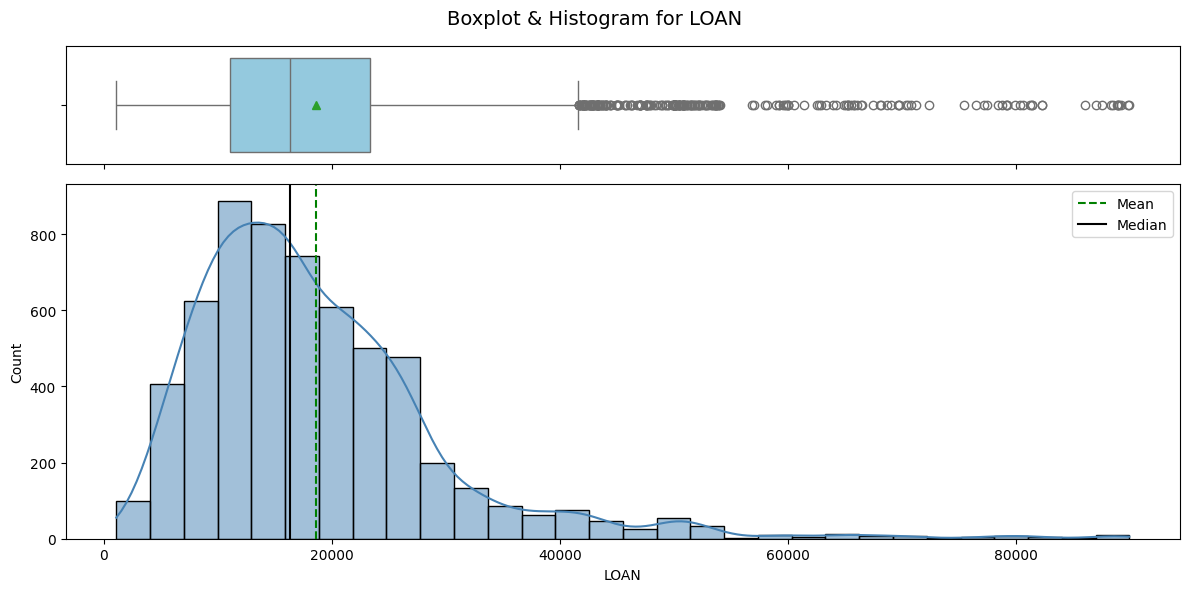

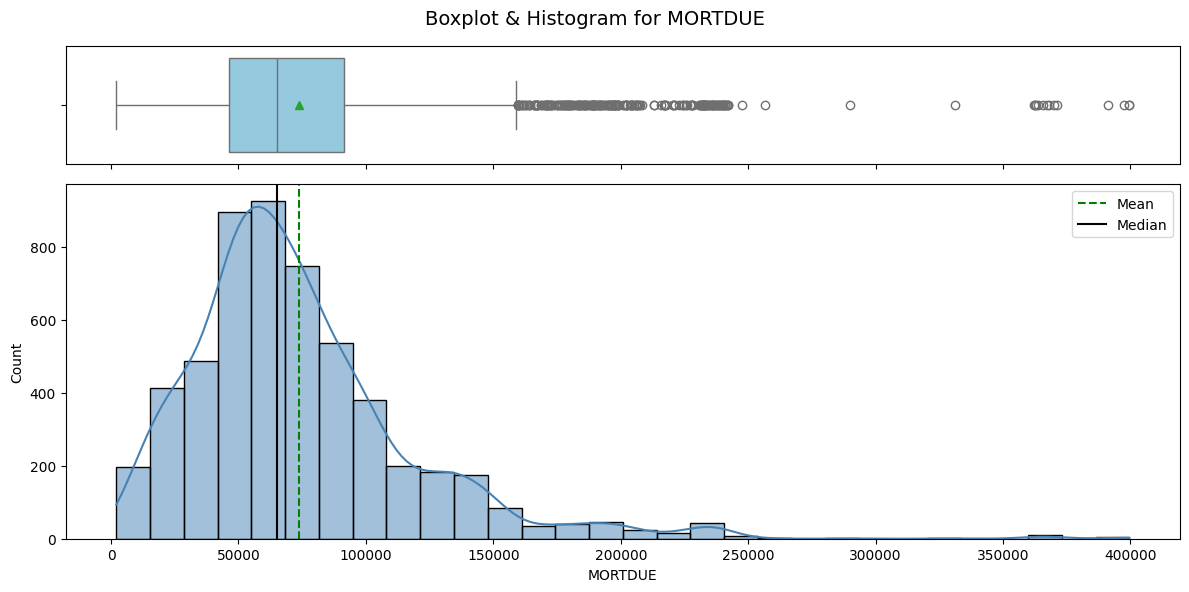

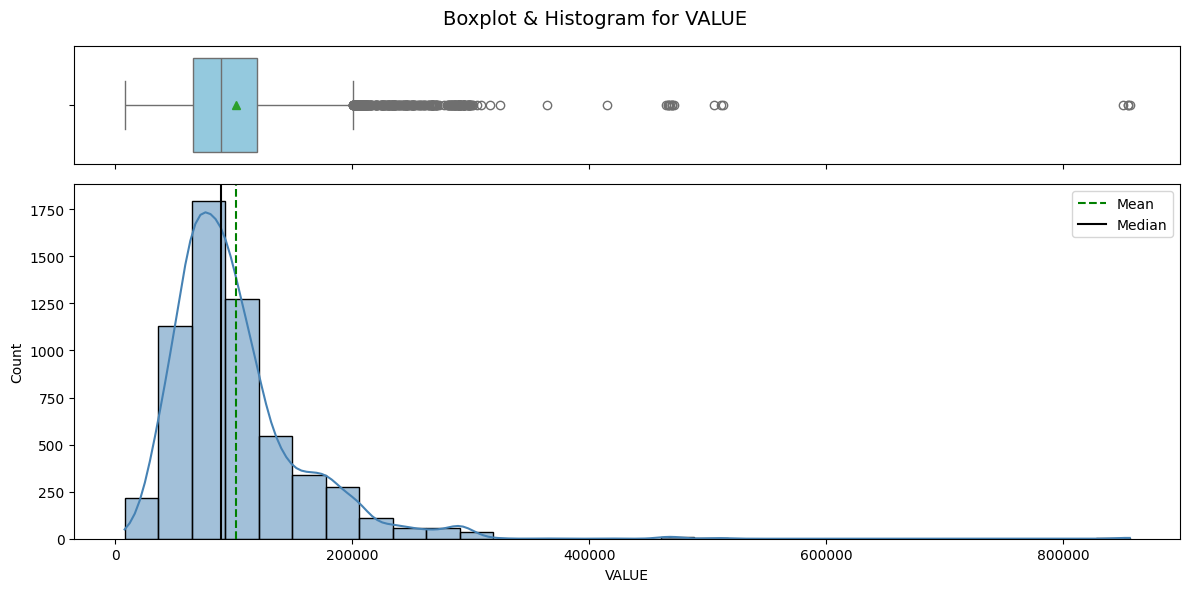

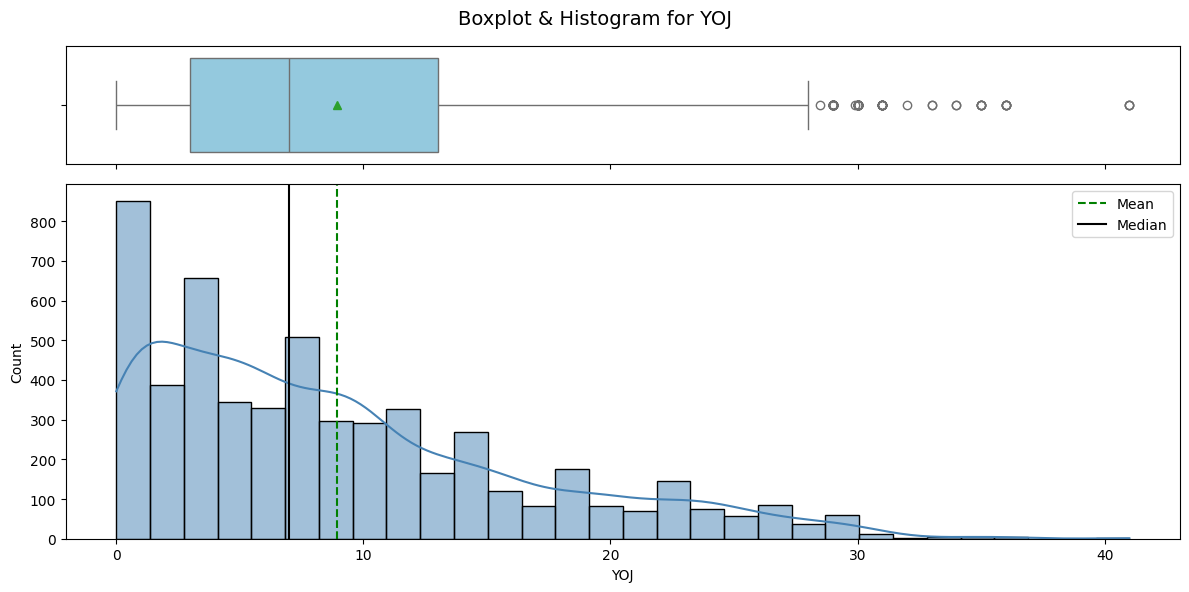

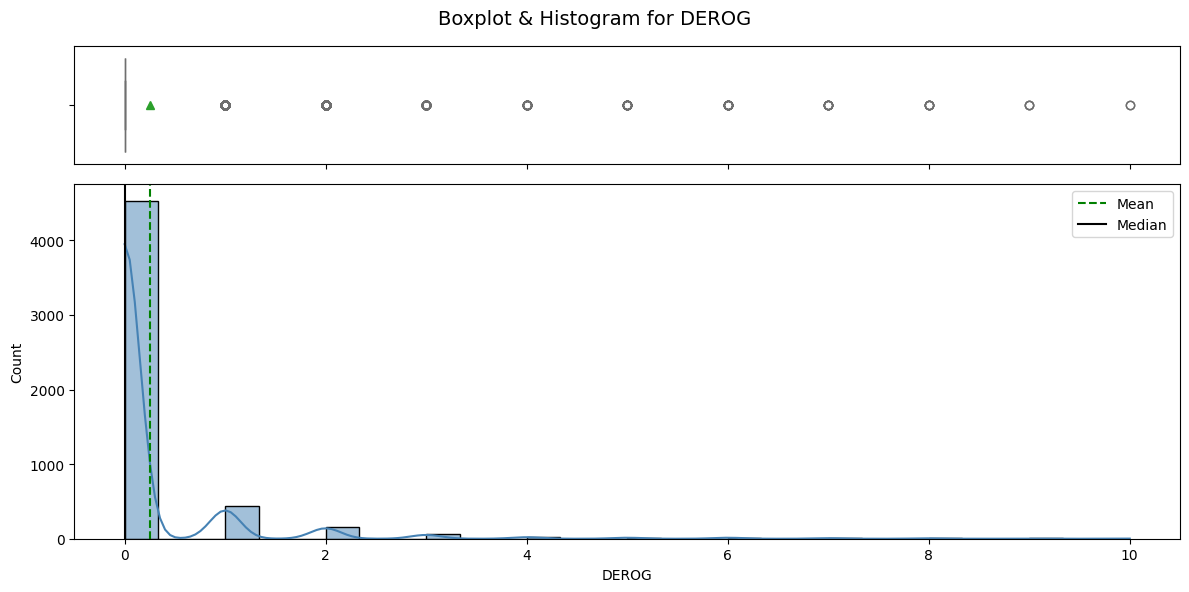

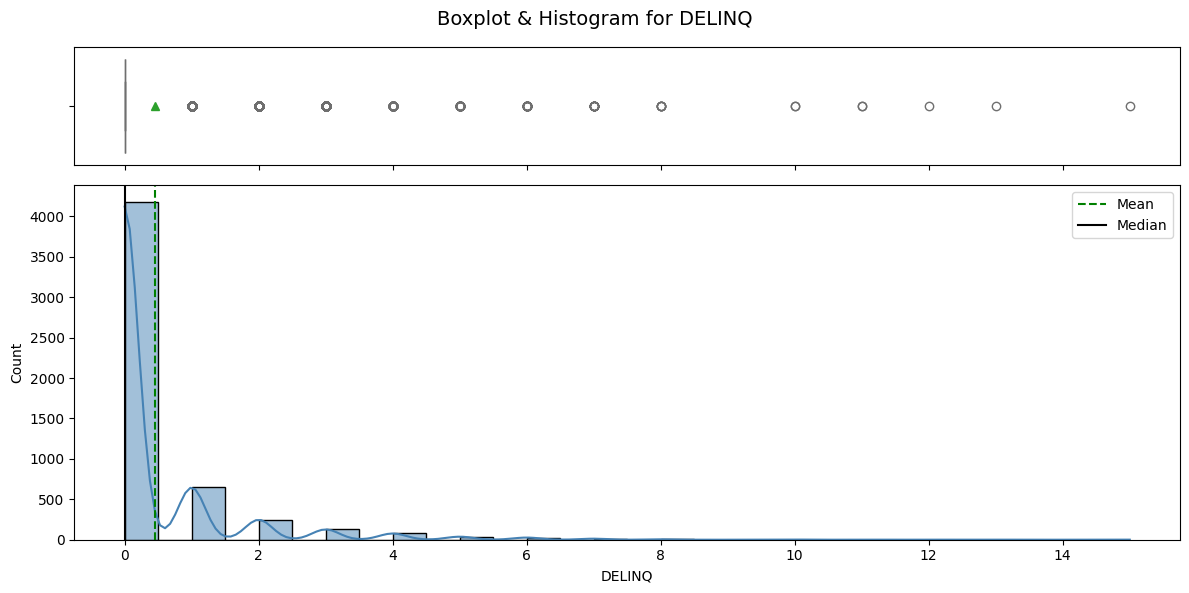

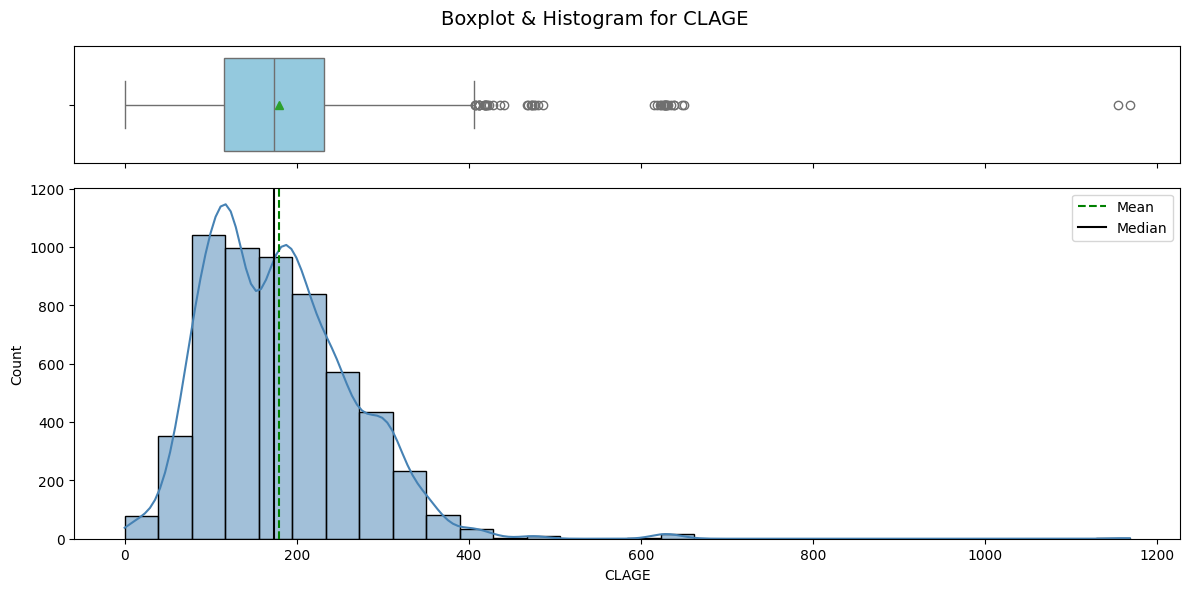

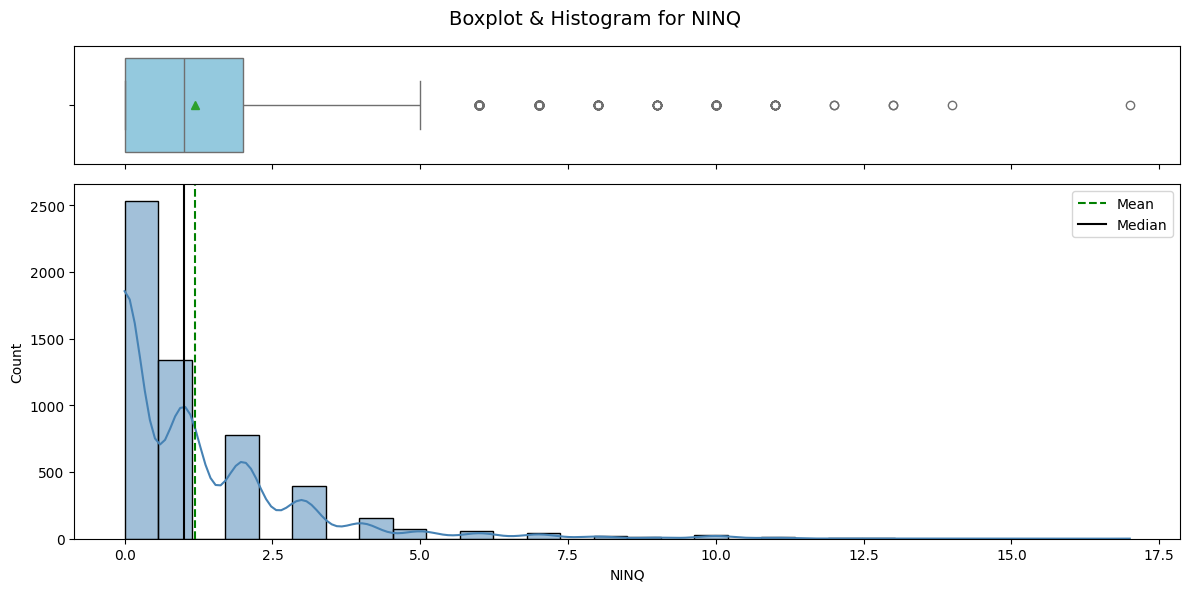

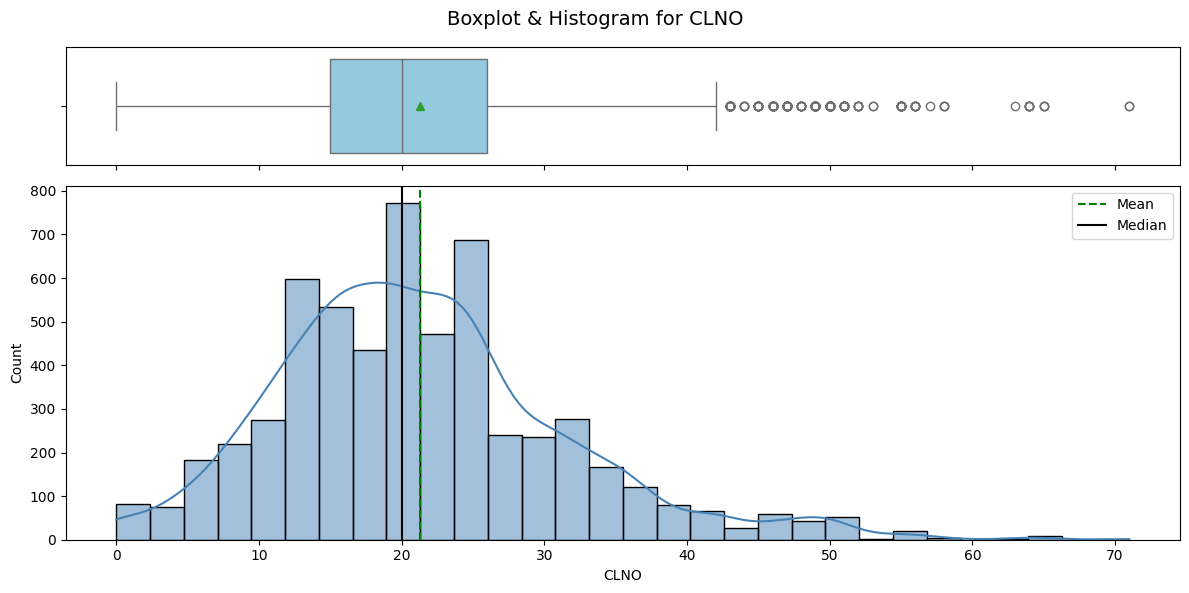

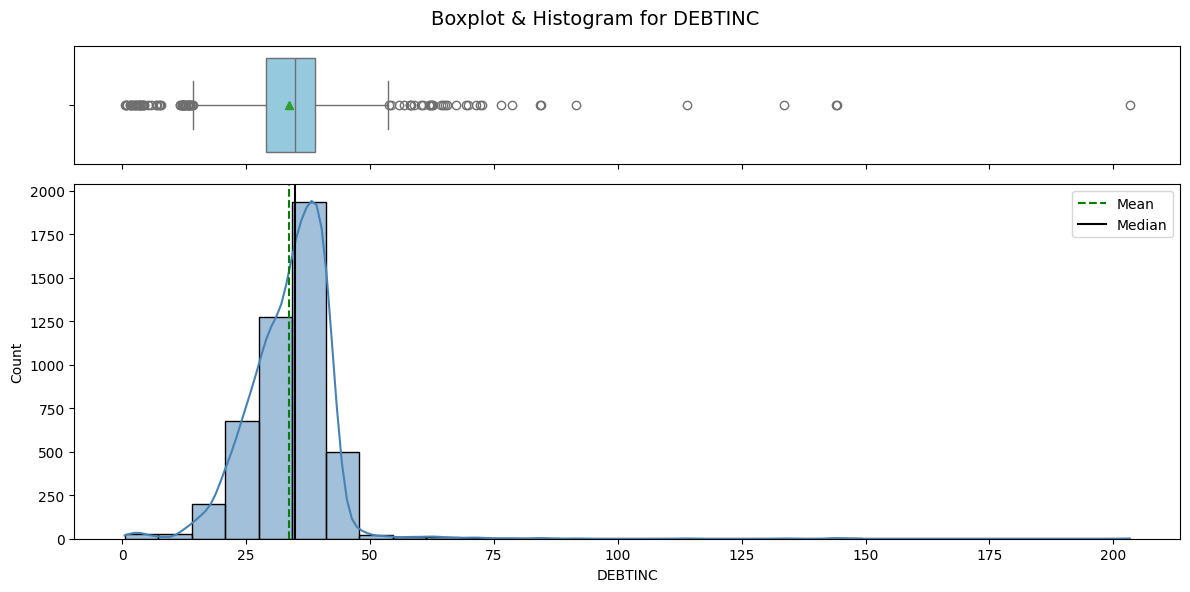

In [11]:
for col in num_cols:
    histogram_boxplot(df, col, kde=True)

##  EDA Insights: Numerical Variable Distributions

This detailed histogram + boxplot analysis revealed key patterns in the dataset:
- Many variables are **right-skewed** (LOAN, MORTDUE, VALUE, DEROG, DEBTINC), justifying **log transformation** or binning.
- Features like `DEROG`, `DELINQ`, and `DEBTINC` exhibit patterns linked to **credit risk** and will be central to modeling.
- Several numeric fields show **valid but extreme outliers** (e.g. property values > $600K). Rather than drop, will transform.
- **YOJ** and **CLAGE** suggest borrower stability. Gaps in YOJ will be imputed by JOB category.
These insights guide our preprocessing and feature engineering strategies to improve model performance.


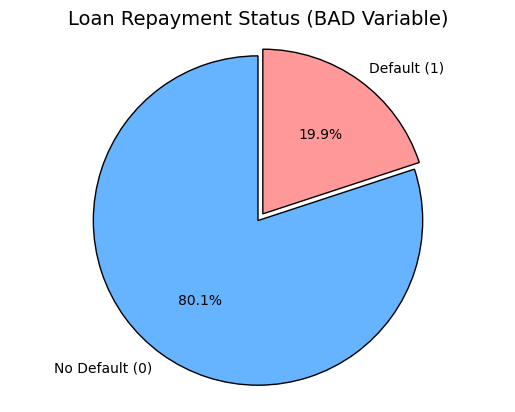

In [12]:
# Calculate default proportions
default_counts = df['BAD'].value_counts()
labels = ['No Default (0)', 'Default (1)']

# Plot pie chart
default_counts.plot(
    kind='pie',
    labels=labels,
    explode=[0.05, 0],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Loan Repayment Status (BAD Variable)", fontsize=14)
plt.ylabel('')  
plt.axis('equal')  
plt.show()


About ~20% of applicants defaulted (BAD = 1) and ~80% repaid. There is some class imbalance, but it's manageable without special sampling techniques yet. Recall and AUC will be more informative than accuracy.

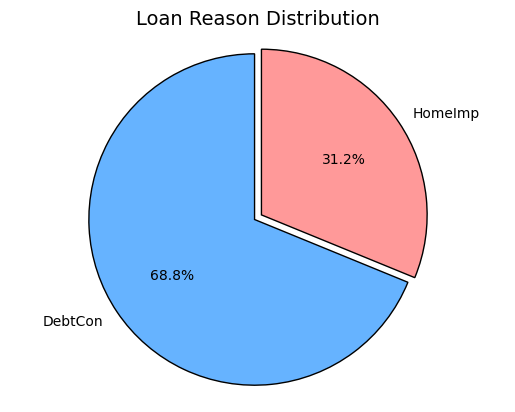

In [13]:
# Value counts for REASON
reason_counts = df['REASON'].value_counts()
labels = reason_counts.index.tolist()
colors = ['#66b3ff', '#ff9999']  # Customize based on # of categories

# Pie chart
reason_counts.plot(
    kind='pie',
    labels=labels,
    autopct='%1.1f%%',
    explode=[0.05, 0],
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Loan Reason Distribution", fontsize=14)
plt.ylabel('')
plt.axis('equal')  # Equal aspect ratio for perfect circle
plt.show()


Majority of applicants ~69% requested loans for debt consolidation, which may indicate higher financial stress or prior credit usage.

Only ~31% applied for home improvement, which could reflect a stronger financial position, as they are investing in their property.

JOB value counts:
JOB
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64


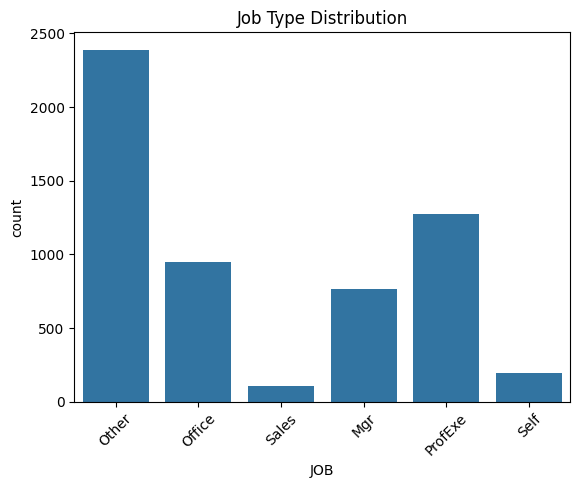

In [14]:
# JOB -> Manager, Office, Sales, Self-employed, Professional/Executive, Other
print("JOB value counts:")
print(df['JOB'].value_counts())

sns.countplot(x='JOB', data=df)
plt.title("Job Type Distribution")
plt.xticks(rotation=45)
plt.show()

Most of Job Type Distribution is Other, may not be a strong predictor

### **Bivariate Analysis**

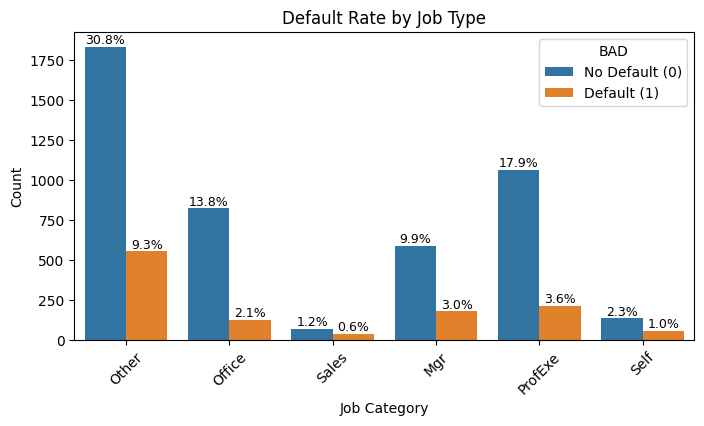

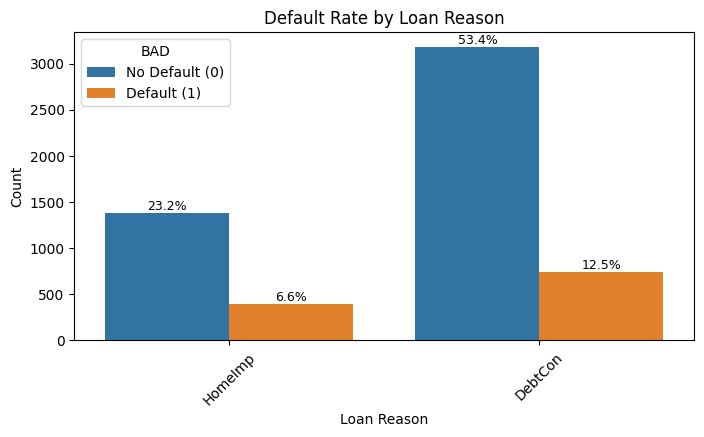

In [15]:
# Plot 1: JOB vs BAD with % annotations
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='JOB', hue='BAD', data=df)

# Title and labels
plt.title("Default Rate by Job Type")
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="BAD", labels=["No Default (0)", "Default (1)"])

# Add % labels only for non-zero bars
for p in ax.patches:
    count = p.get_height()
    if count > 0:
        x = p.get_x() + p.get_width() / 2.0
        label = f"{100 * count / len(df):.1f}%"
        ax.annotate(label, (x, count), ha='center', va='bottom', fontsize=9)

plt.show()

# Plot 2: REASON vs BAD with % annotations
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='REASON', hue='BAD', data=df)

# Title and labels
plt.title("Default Rate by Loan Reason")
plt.xlabel("Loan Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="BAD", labels=["No Default (0)", "Default (1)"])

# Add % labels only for non-zero bars
for p in ax.patches:
    count = p.get_height()
    if count > 0:
        x = p.get_x() + p.get_width() / 2.0
        label = f"{100 * count / len(df):.1f}%"
        ax.annotate(label, (x, count), ha='center', va='bottom', fontsize=9)

plt.show()

### Default Rate by Job Type – Observations & Insights

- **"Other"** job category is the most frequent (over 2,300 applicants), and it also has the **highest count of defaulters** (9.3%), making it both **common and risky**.
- **Professional/Executive** roles show a relatively moderate default rate (3.6%) despite being the second most common group.
- **Sales** and **Self-employed** are rare job types in the dataset, but still show some default risk.
- **Managerial (Mgr)** and **Office** jobs have moderate to low default rates, suggesting more stable profiles.
- Overall, job type influences default probability, but the **“Other” category stands out** as a risk cluster and may warrant deeper segmentation or investigation.

### Default Rate by Loan Reason – Observations & Insights

- The majority of applicants took loans for **Debt Consolidation (DebtCon)**, accounting for **53.4% of all loans**.
- Loans for **DebtCon also have the highest number of defaults** (12.5%), suggesting that applicants using loans to consolidate debt may already be in financial distress.
- In contrast, **Home Improvement (HomeImp)** loans have a lower default percentage (6.6%) and a smaller population share.
- This aligns with domain intuition: borrowers taking loans for **asset-enhancing purposes (e.g., HomeImp)** are generally more creditworthy than those consolidating debt.
- The loan **purpose is an important categorical predictor** of default risk and should be retained in modeling.

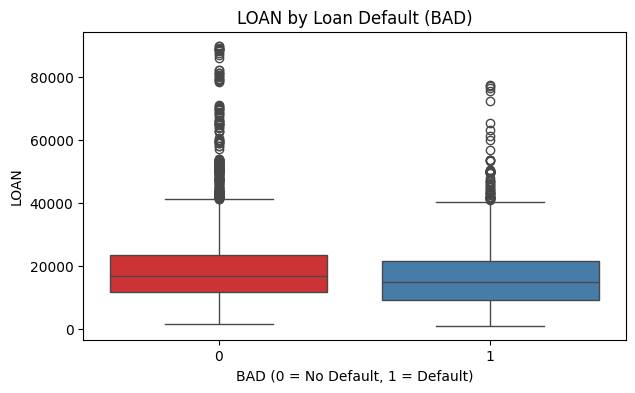

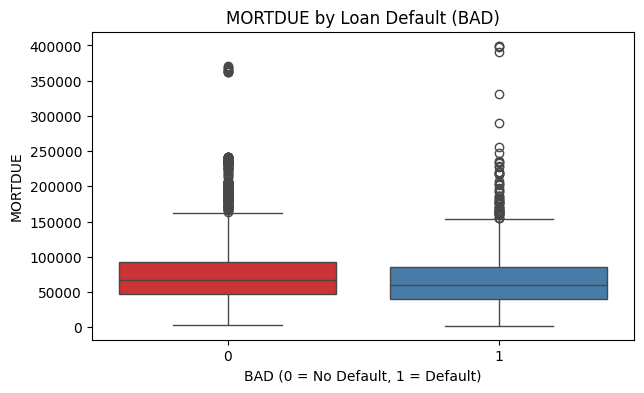

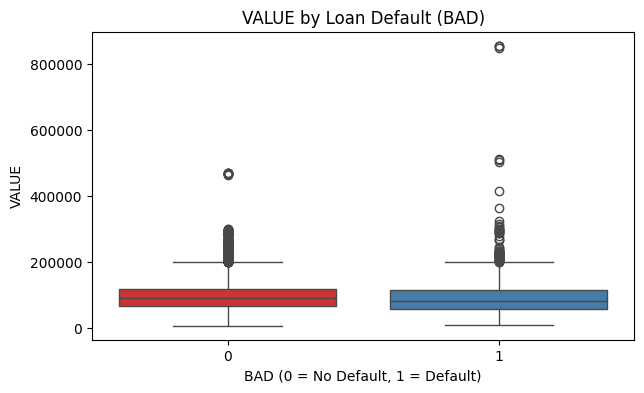

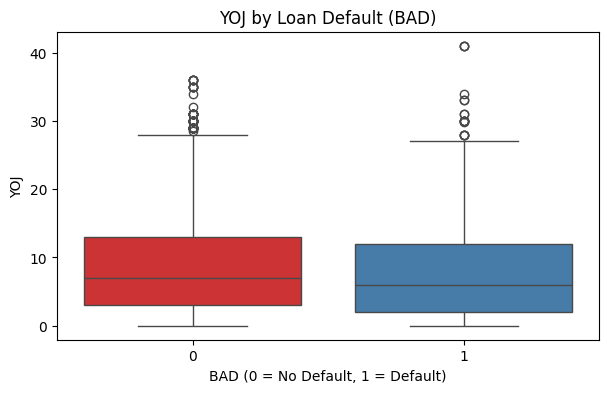

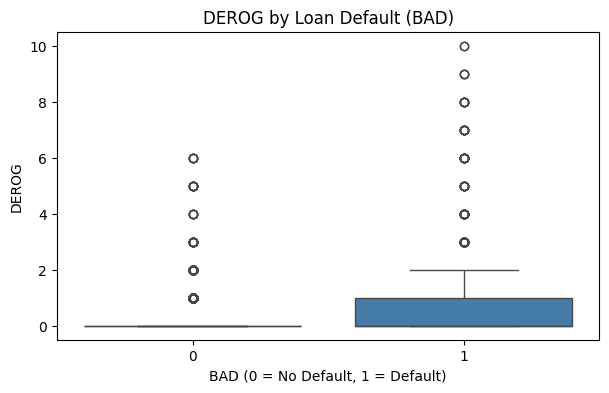

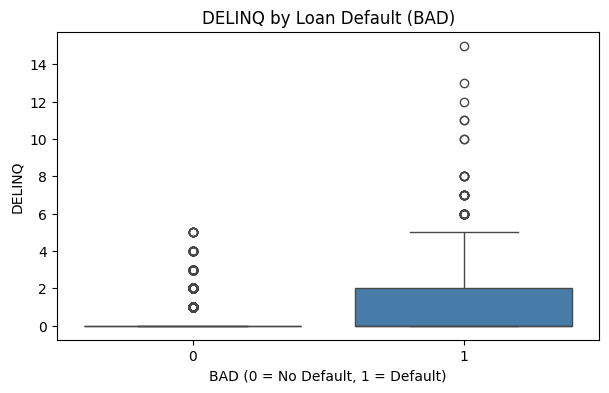

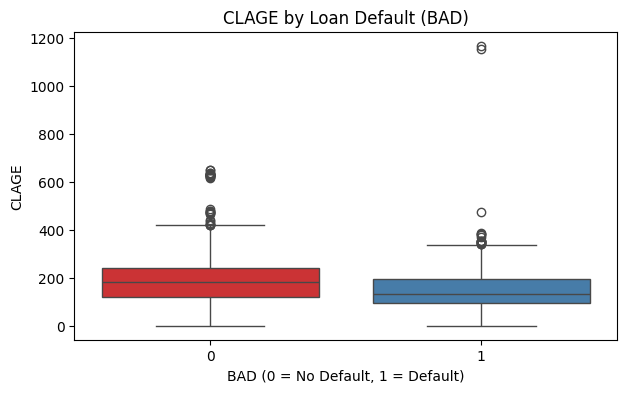

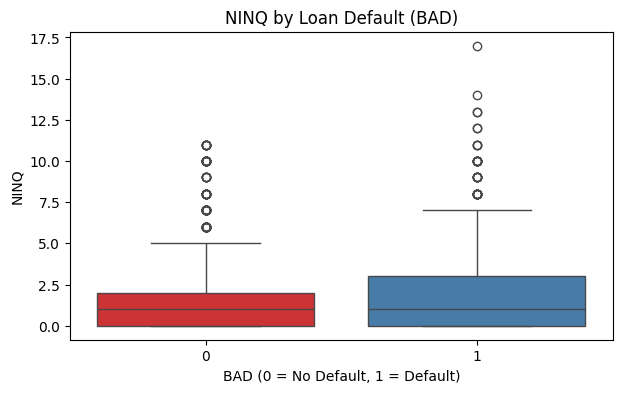

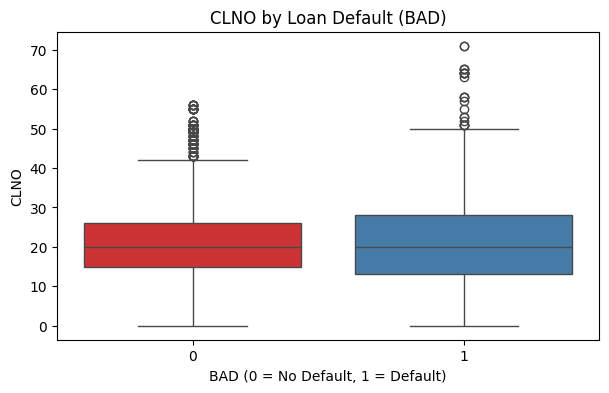

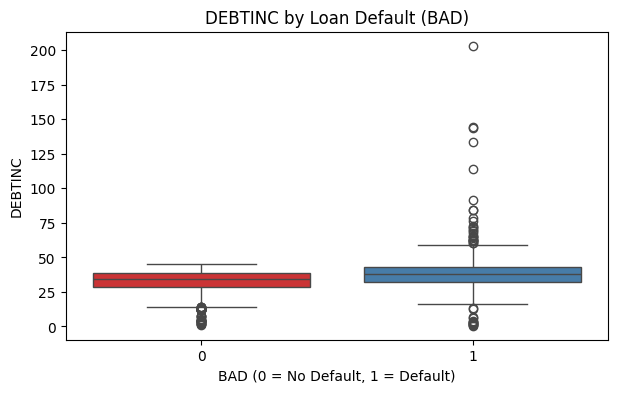

In [16]:
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x='BAD', y=col, hue='BAD', palette='Set1', dodge=False, legend=False)
    plt.title(f"{col} by Loan Default (BAD)")
    plt.xlabel("BAD (0 = No Default, 1 = Default)")
    plt.ylabel(col)
    plt.show()


### **Loan Amount (LOAN):**
- Defaulted customers (BAD=1) tend to have slightly lower median loan amounts than non-defaulters
- Both groups have significant outliers, suggesting need for outlier treatment


### **Mortgage Due (MORTDUE) and Property Value (VALUE):**
- Both distributions show wide ranges with heavy right-skewness
- Defaulted loans show somewhat lower median values than non-defaults, indicating less collateral or equity may relate to higher default risk


### **Years on Job (YOJ):**
- Defaulters show slightly lower job tenure on average
- Suggests employment stability could be a relevant predictor for risk


### **DEROG & DELINQ (Credit History):**
- Strong separation: Defaults have higher counts of derogatory reports and delinquencies
- These variables appear highly predictive of default behavior


### **CLAGE (Credit Line Age):**
- Slightly older credit lines are more typical for non-defaulters
- Longer credit history may correlate with trustworthiness


### **NINQ (Recent Credit Inquiries):**
- Defaulters generally have more recent credit inquiries
- May indicate financial distress or aggressive credit-seeking behavior


### **CLNO (Number of Credit Lines):**
- Similar distributions across both groups, though defaulters show slightly more variation


### **DEBTINC (Debt-to-Income Ratio):**
- Higher debt ratios are seen in defaulters
- Indicates that higher financial burden increases risk of default

### Extra Observations
- Feature engineering and capping directly mitigate issues like skewness and data sparsity, leading to better model generalization
- These insights validate that default behavior is strongly linked to credit history and financial burden

### **Multivariate Analysis**

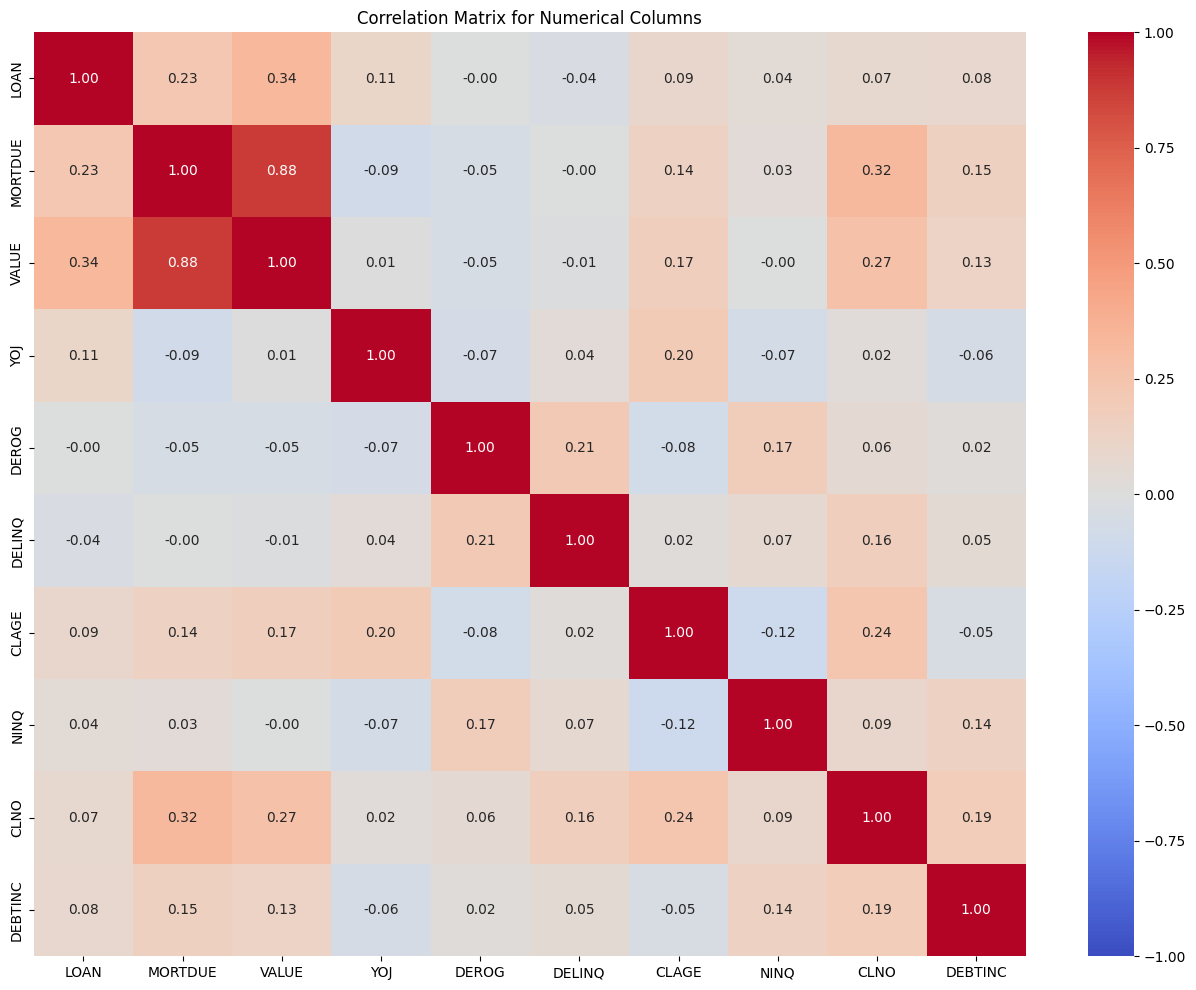

In [17]:
# Build correlation matrix for numerical columns
corr = df[num_cols].corr()

# Plot the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1,
            annot=True, fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

To better understand relationships between numerical variables, especially to detect multicollinearity or redundancy.

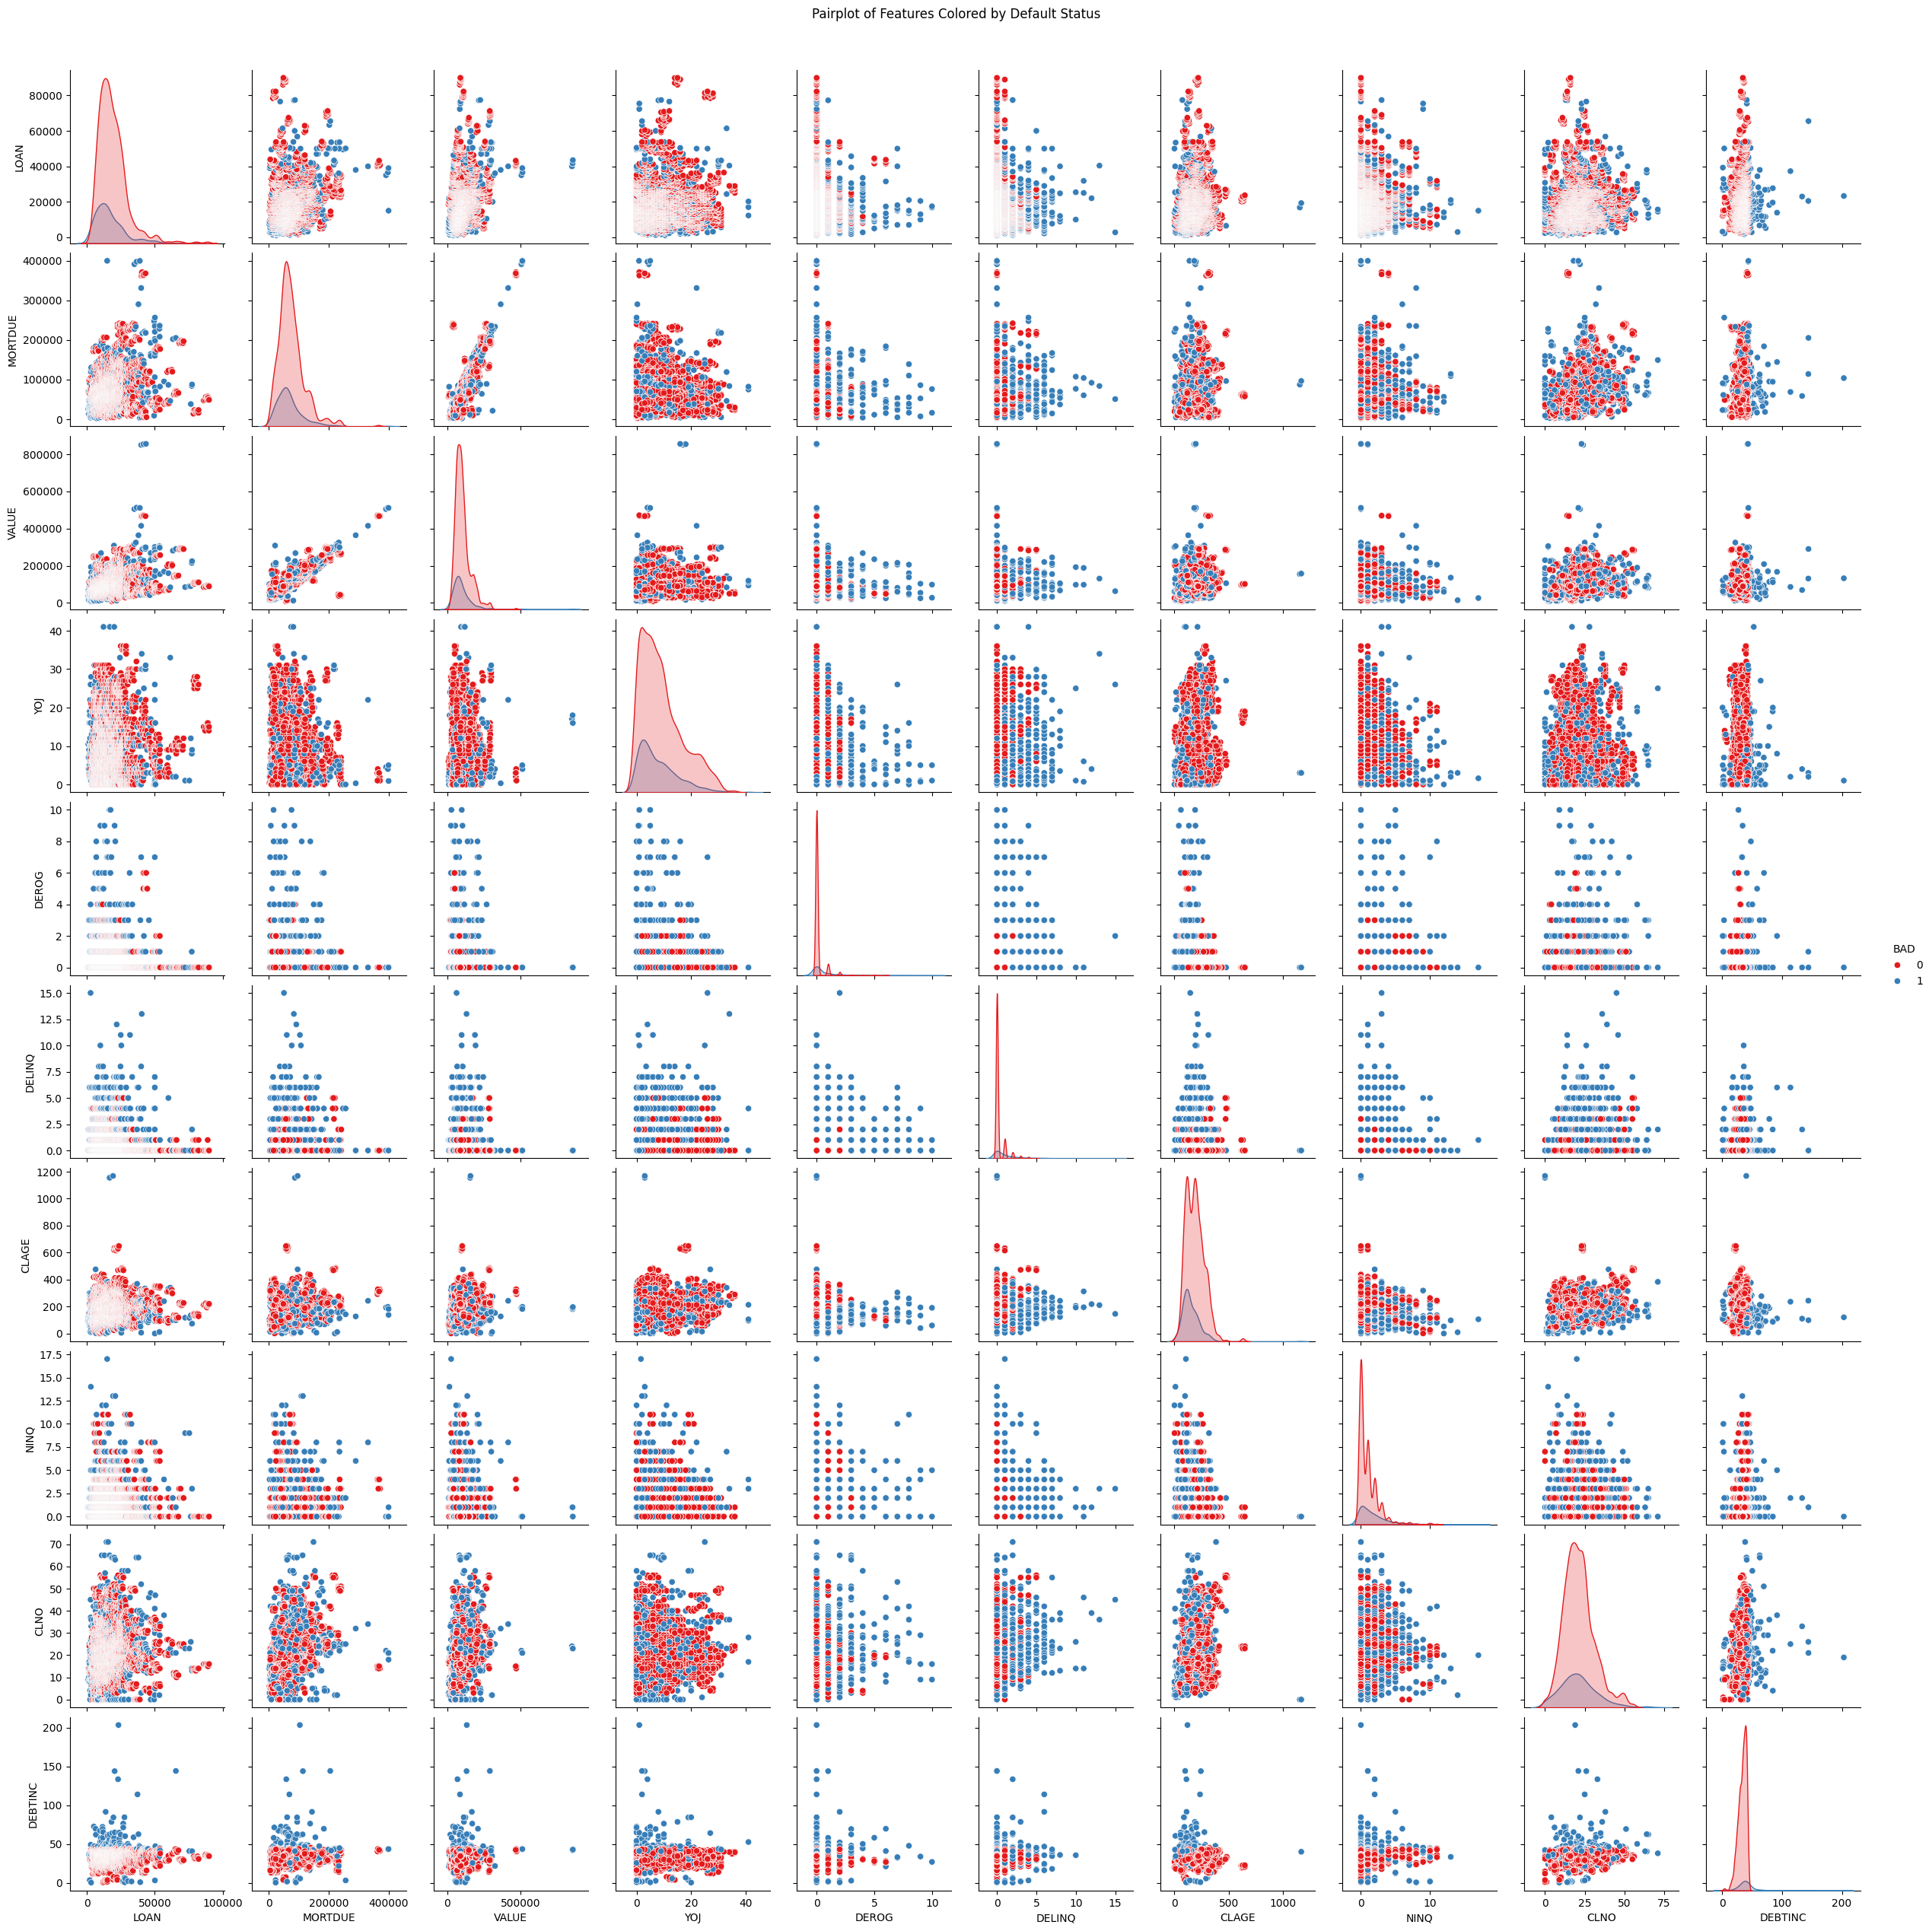

In [18]:
sns.pairplot(df, hue='BAD', diag_kind='kde', palette='Set1')
plt.suptitle('Pairplot of Features Colored by Default Status', y=1.02)
plt.show()

## 1. Strongest Separators (Red vs Blue Clusters are Most Distinct):
### DEROG vs DELINQ / CLNO / NINQ:
- Defaults (red) cluster at higher values of DEROG and DELINQ, indicating poor credit history.

- DEROG and DELINQ exhibit near-zero values for most non-defaulters (blue), showing high discriminatory power.

### DEBTINC vs CLAGE / NINQ:

Defaulters tend to have higher DEBTINC and more recent inquiries (NINQ), but often shorter credit history (CLAGE).

This trio reflects financial stress indicators.

## 2. Linear Relationships Between Variables (General Correlations):
### LOAN vs MORTDUE / VALUE:

- Positive linear relationship, with VALUE generally exceeding MORTDUE, consistent with how secured loans function.

- Some outliers may indicate high-risk profiles or extreme cases.

### CLAGE vs CLNO:

- Weak positive correlation – customers with longer credit age often have more credit lines.

## 3. Overlap Between Classes (Less Discriminative):
### YOJ vs CLAGE / LOAN:

- Defaulters and non-defaulters are heavily overlapped, making YOJ (years on job) a less discriminative feature alone.

### NINQ vs CLNO:

- Considerable scatter across both classes; interaction effects or transformation may be needed.

## 4. Feature Distributions:
### Diagonal KDE Plots (Histograms):

- DEROG, DELINQ, NINQ, and DEBTINC have right-skewed distributions.

- CLAGE, VALUE, and MORTDUE also show strong skewness, justifying transformations or binning during preprocessing.

## Key Takeaways:
- Variables like DEROG, DELINQ, DEBTINC, and NINQ show clear distinction between defaulters and non-defaulters → highly predictive.

- There is evidence of non-linear relationships and class imbalance, reinforcing the value of tree-based models like Random Forest or XGBoost.

- Outliers and skewed distributions are visible and must be treated for better generalization.

- Feature interactions matter (e.g., high DEBTINC + many NINQ = higher risk).

## Treating Missing Values

In [19]:
# Fill CATEGORICAL features with 'Other'
df['REASON'] = df['REASON'].fillna('Other')
df['JOB'] = df['JOB'].fillna('Other')

# Fill CREDIT HISTORY fields with 0 (assuming no issues)
for col in ['DEROG', 'DELINQ', 'NINQ']:
    df[col] = df[col].fillna(0)

# Fill skewed NUMERIC features with median to preserve central tendency and avoid outlier distortion
for col in ['MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']:
    df[col] = df[col].fillna(df[col].median())

# Group-wise median imputation for YOJ based on JOB
df['YOJ'] = df.groupby('JOB')['YOJ'].transform(lambda x: x.fillna(x.median()))

print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


## Treating Outliers

In [20]:
def cap_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        df[col] = np.where(df[col] > upper_bound, upper_bound,
                  np.where(df[col] < lower_bound, lower_bound, df[col]))
    return df

In [21]:
# Columns to apply IQR capping
cap_cols = ['LOAN', 'MORTDUE', 'VALUE', 'DEBTINC', 'CLNO', 'NINQ', 'DEROG', 'DELINQ']
df = cap_outliers_iqr(df, cap_cols)


## **Important Insights from EDA**

What are the the most important observations and insights from the data based on the EDA performed?

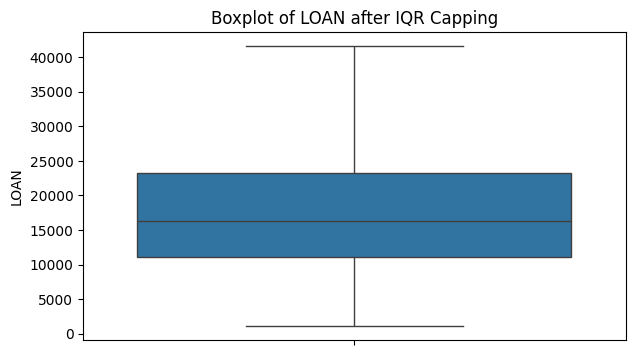

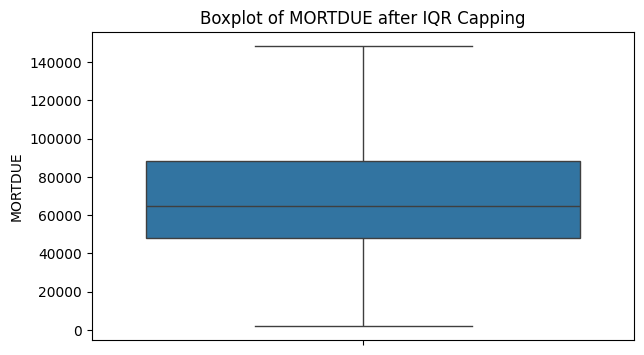

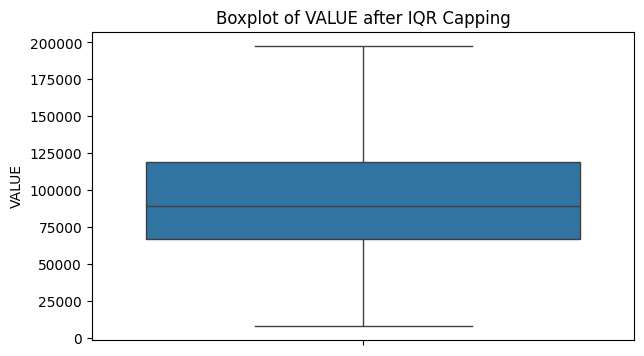

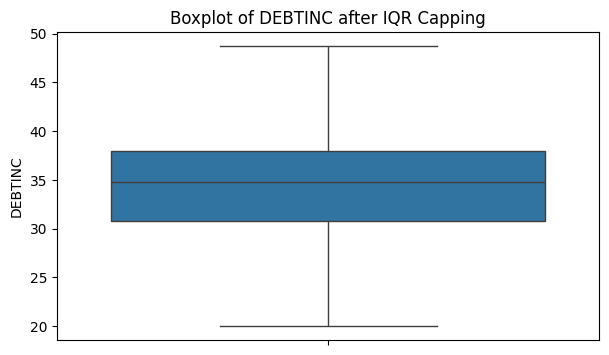

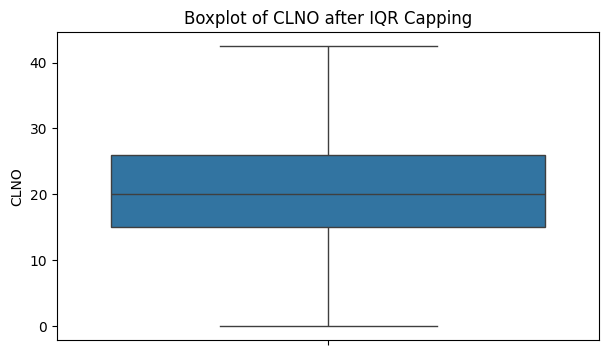

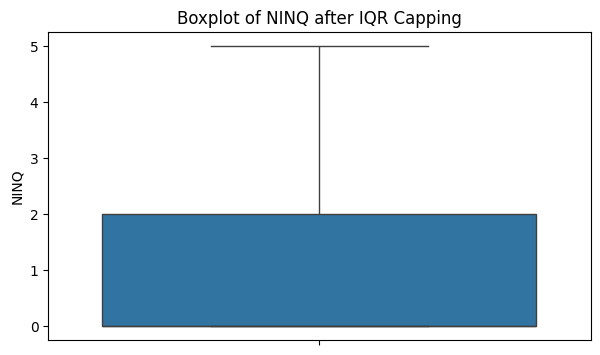

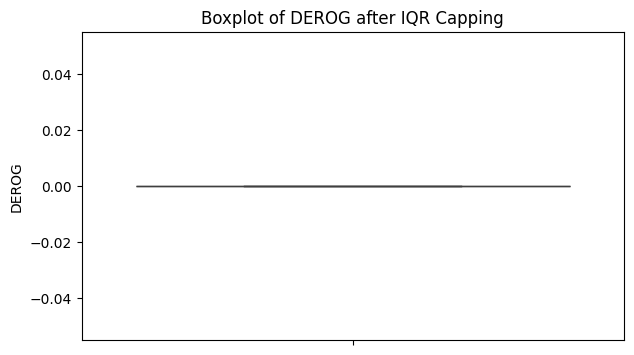

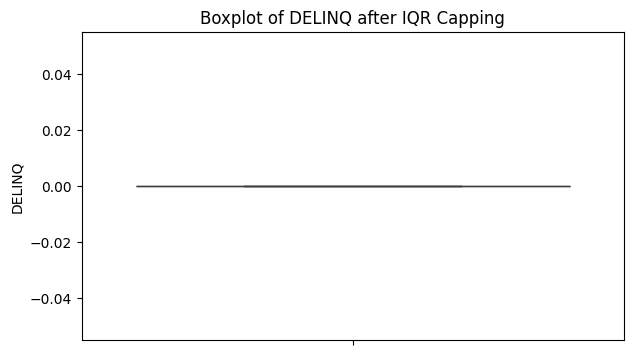

In [22]:
# Check for outliers again
for col in cap_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col} after IQR Capping")
    plt.show() 

In [23]:
df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [24]:
print("LOAN mean:", df['LOAN'].mean())
print("LOAN std:", df['LOAN'].std())

LOAN mean: 18051.895973154362
LOAN std: 9252.565294021877


There are no more missing values or extreme outliers.

## **Model Building - Approach**
- Focus on recall to identify defaulters

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   float64
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5960 non-null   object 
 5   JOB      5960 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 605.4+ KB


In [26]:
# Split the data into features and target variable
X = df.drop(columns='BAD')
y = df['BAD']

# Ensure enough class diversity
print("Class distribution:\n", y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

# Check the shape of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Class distribution:
 BAD
0    4771
1    1189
Name: count, dtype: int64
X_train shape: (4768, 12)
X_test shape: (1192, 12)
y_train shape: (4768,)
y_test shape: (1192,)


In [27]:
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 
            'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [28]:
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 BAD
0    3817
1     951
Name: count, dtype: int64
Test class distribution:
 BAD
0    954
1    238
Name: count, dtype: int64


## **Logistic Regression**

In [29]:
# Define column types
cat_cols = ['REASON', 'JOB']
num_cols = [col for col in X_train.columns if col not in cat_cols]

# Preprocessing: scaling + encoding
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OrdinalEncoder(), cat_cols)
])

# Build pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=44))
])

# Fit model
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

y_train_pred = logreg_pipeline.predict(X_train)
y_train_proba = logreg_pipeline.predict_proba(X_train)[:, 1]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.88      0.63      0.74      3817
           1       0.31      0.65      0.42       951

    accuracy                           0.64      4768
   macro avg       0.59      0.64      0.58      4768
weighted avg       0.77      0.64      0.67      4768

Accuracy: 0.64
Precision: 0.31
Recall: 0.65
F1 Score: 0.42
AUC Score: 0.7


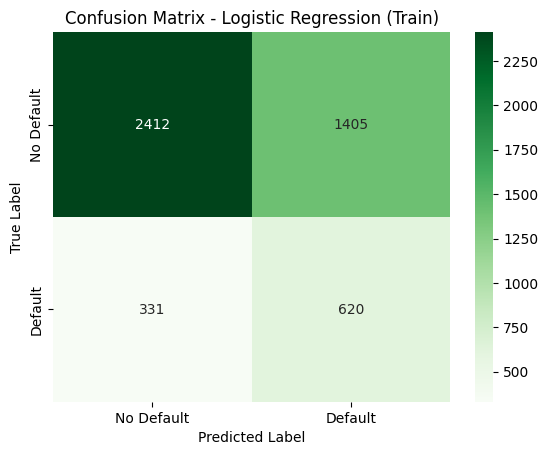

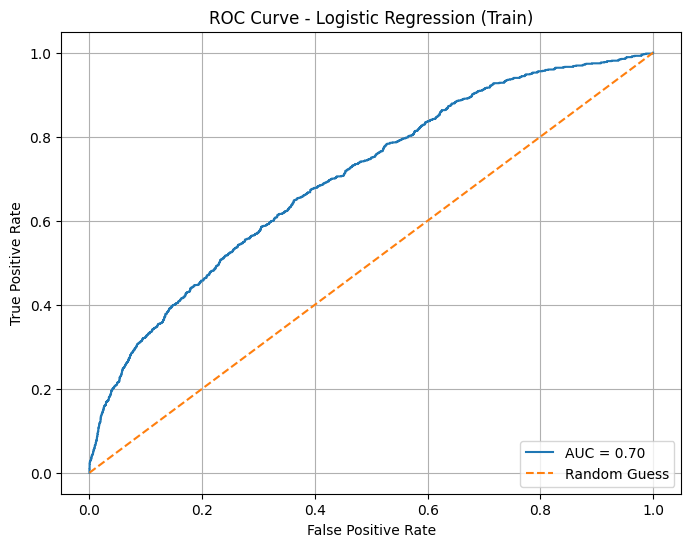

In [ ]:
# Evaluation on training set
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Round and print metrics
print("Accuracy:", round(accuracy_score(y_train, y_train_pred), 2))
print("Precision:", round(precision_score(y_train, y_train_pred), 2))
print("Recall:", round(recall_score(y_train, y_train_pred), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred), 2))
print("AUC Score:", round(roc_auc_score(y_train, y_train_proba), 2))

# Confusion Matrix with Labels
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Logistic Regression (Train)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"AUC = {roc_auc_score(y_train, y_train_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Train)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.63      0.73       954
           1       0.31      0.65      0.42       238

    accuracy                           0.64      1192
   macro avg       0.59      0.64      0.58      1192
weighted avg       0.76      0.64      0.67      1192

Accuracy: 0.64
Precision: 0.31
Recall: 0.65
F1 Score: 0.42
AUC Score: 0.69


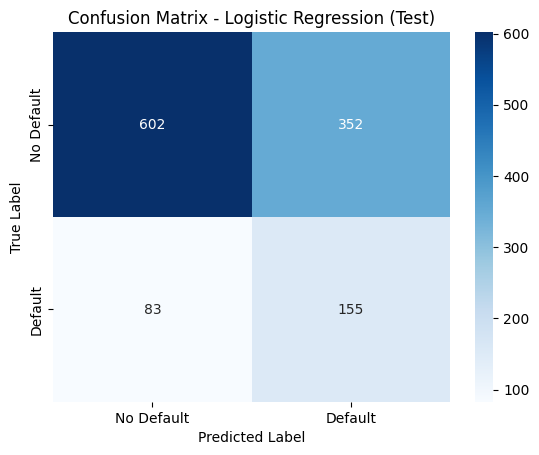

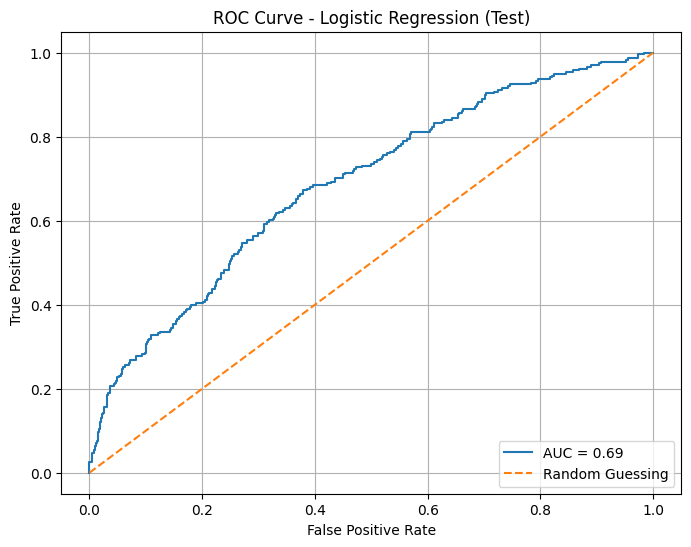

In [31]:
# Evaluation on test set
print("Classification Report (Test):")
print(classification_report(y_test, y_pred))

# Round and print individual metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("Precision:", round(precision_score(y_test, y_pred), 2))
print("Recall:", round(recall_score(y_test, y_pred), 2))
print("F1 Score:", round(f1_score(y_test, y_pred), 2))
print("AUC Score:", round(roc_auc_score(y_test, y_proba), 2))

# Confusion Matrix with Labels
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Logistic Regression (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save metrics for comparison table later
logreg_metrics = {
    'model': 'Logistic Regression',
    'accuracy': round(accuracy_score(y_test, y_pred), 2),
    'precision': round(precision_score(y_test, y_pred), 2),
    'recall': round(recall_score(y_test, y_pred), 2),
    'f1': round(f1_score(y_test, y_pred), 2),
    'auc': round(roc_auc_score(y_test, y_proba), 2)
}

### Strengths: Interpretable baseline, fair recall (0.65).

### Weaknesses: Low precision (0.31) and F1-score (0.42), meaning high false positives.

### Conclusion: Poor performance overall. Acts as a benchmark but lacks predictive power for this problem.



## **Decision Tree**

In [32]:
# Columns setup (same as before)
cat_cols = ['REASON', 'JOB']
num_cols = [col for col in X_train.columns if col not in cat_cols]

# Preprocessing: only encoding (no scaling needed for tree)
tree_preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), cat_cols)
], remainder='passthrough')

# Decision Tree Model Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Train model
dt_pipeline.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

# Predict on training as well for comparison later
y_train_pred_dt = dt_pipeline.predict(X_train)
y_train_proba_dt = dt_pipeline.predict_proba(X_train)[:, 1]

Decision Tree Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      3817
           1       0.56      0.91      0.69       951

    accuracy                           0.84      4768
   macro avg       0.77      0.86      0.79      4768
weighted avg       0.89      0.84      0.85      4768

Accuracy: 0.84
Precision: 0.56
Recall: 0.91
F1 Score: 0.69
AUC Score: 0.94


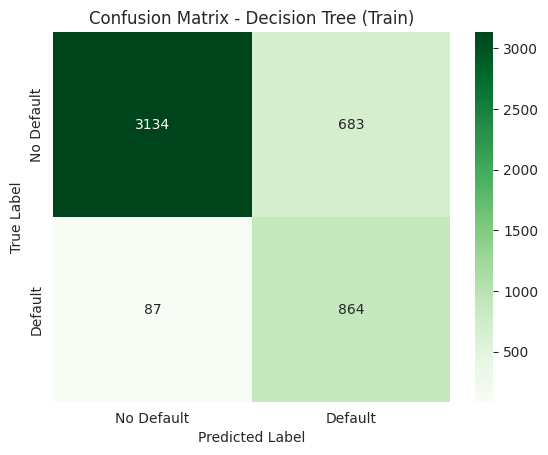

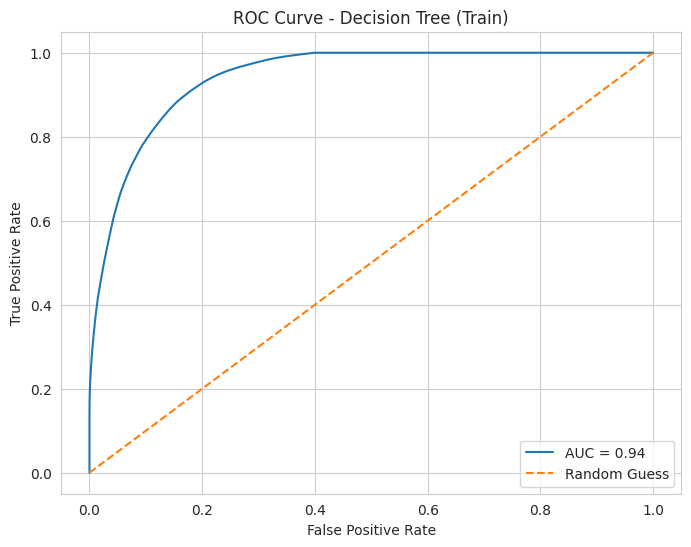

In [ ]:
# Train set evaluation
print("Decision Tree Classification Report (Train):")
print(classification_report(y_train, y_train_pred_dt))

# Round and print metrics
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_dt), 2))
print("Precision:", round(precision_score(y_train, y_train_pred_dt), 2))
print("Recall:", round(recall_score(y_train, y_train_pred_dt), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred_dt), 2))
print("AUC Score:", round(roc_auc_score(y_train, y_train_proba_dt), 2))

# Confusion Matrix with Labels
cm_train_dt = confusion_matrix(y_train, y_train_pred_dt)
sns.heatmap(cm_train_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Decision Tree (Train)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr_train_dt, tpr_train_dt, _ = roc_curve(y_train, y_train_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_dt, tpr_train_dt, label=f"AUC = {roc_auc_score(y_train, y_train_proba_dt):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Train)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification Report (Test - Decision Tree):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       954
           1       0.60      0.54      0.57       238

    accuracy                           0.84      1192
   macro avg       0.75      0.72      0.73      1192
weighted avg       0.83      0.84      0.83      1192

Accuracy: 0.84
Precision: 0.6
Recall: 0.54
F1 Score: 0.57
AUC Score: 0.72


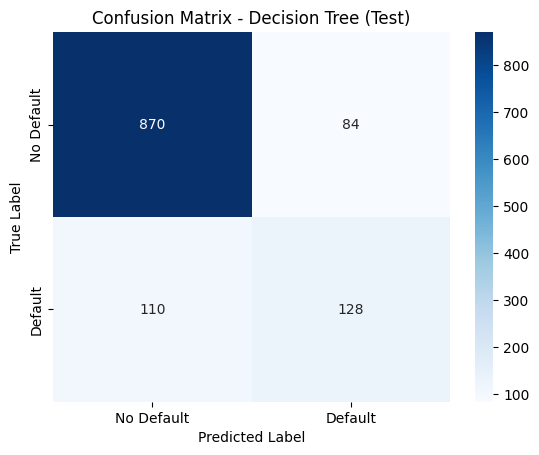

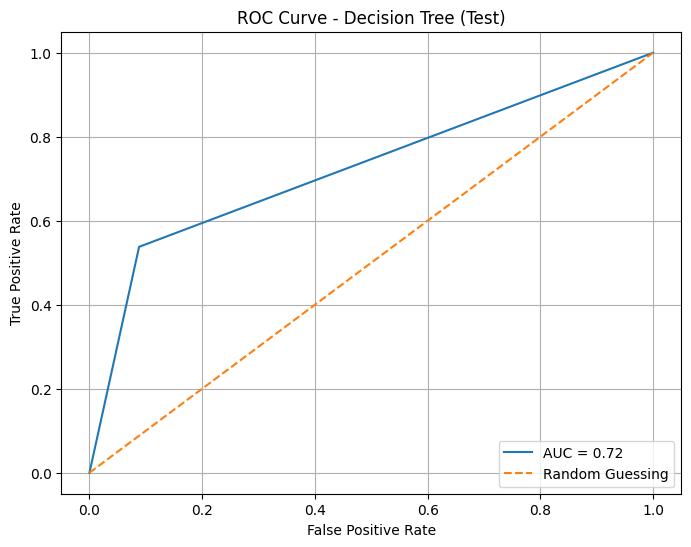

In [33]:
# Test set evaluation
print("Classification Report (Test - Decision Tree):")
print(classification_report(y_test, y_pred_dt))

print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 2))
print("Precision:", round(precision_score(y_test, y_pred_dt), 2))
print("Recall:", round(recall_score(y_test, y_pred_dt), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_dt), 2))
print("AUC Score:", round(roc_auc_score(y_test, y_proba_dt), 2))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Decision Tree (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {roc_auc_score(y_test, y_proba_dt):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save metrics
dt_metrics = {
    'model': 'Decision Tree',
    'accuracy': round(accuracy_score(y_test, y_pred_dt), 2),
    'precision': round(precision_score(y_test, y_pred_dt), 2),
    'recall': round(recall_score(y_test, y_pred_dt), 2),
    'f1': round(f1_score(y_test, y_pred_dt), 2),
    'auc': round(roc_auc_score(y_test, y_proba_dt), 2)
}


### Shows overfitting (Train AUC = 0.94 vs Test AUC = 0.72)

### Still generalizes better than Logistic Regression, especially in identifying defaulters.

### Conclusion: Simpler and better than baseline, but prone to overfitting.

### **Decision Tree - Hyperparameter Tuning**

In [34]:
# Preprocessing
cat_cols = ['REASON', 'JOB']
num_cols = [col for col in X_train.columns if col not in cat_cols]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OrdinalEncoder(), cat_cols)
])

# Classifier
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt)
])

In [35]:
# Parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Grid Search with Recall as scoring
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 2}


Classification Report (Train - Tuned Decision Tree):
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      3817
           1       0.56      0.91      0.69       951

    accuracy                           0.84      4768
   macro avg       0.77      0.86      0.79      4768
weighted avg       0.89      0.84      0.85      4768

Accuracy: 0.84
Precision: 0.56
Recall: 0.91
F1 Score: 0.69
AUC Score: 0.94


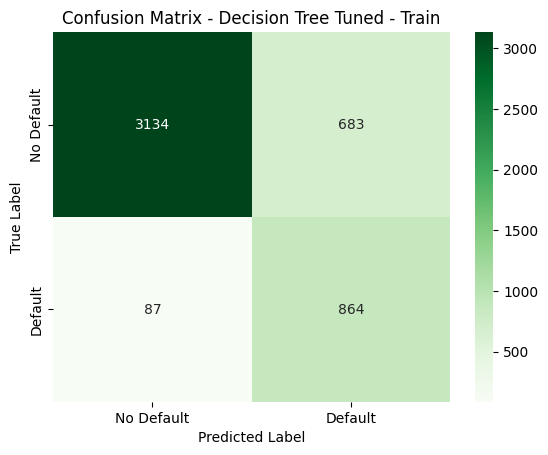

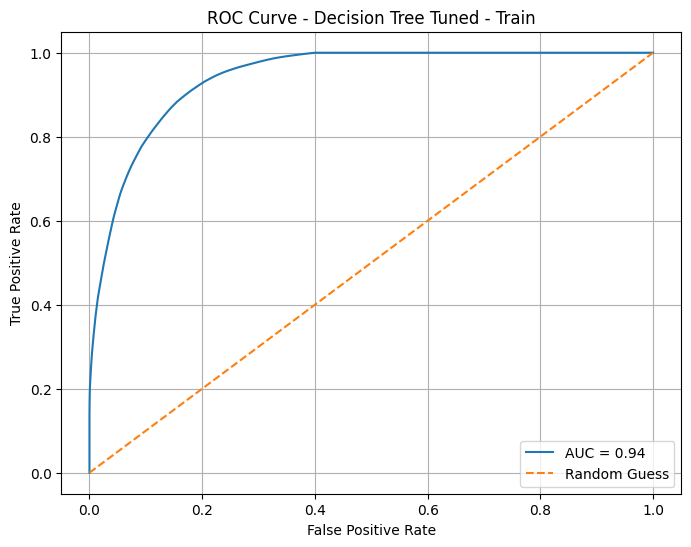

In [36]:
# Predict on training set
y_train_pred_dt = best_dt.predict(X_train)
y_train_proba_dt = best_dt.predict_proba(X_train)[:, 1]
# Evaluation on training set
print("Classification Report (Train - Tuned Decision Tree):")
print(classification_report(y_train, y_train_pred_dt))
# Round and print metrics
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_dt), 2))
print("Precision:", round(precision_score(y_train, y_train_pred_dt), 2))
print("Recall:", round(recall_score(y_train, y_train_pred_dt), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred_dt), 2))
print("AUC Score:", round(roc_auc_score(y_train, y_train_proba_dt), 2))
# Confusion Matrix with Labels
cm_train = confusion_matrix(y_train, y_train_pred_dt)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Decision Tree Tuned - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"AUC = {roc_auc_score(y_train, y_train_proba_dt):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Tuned - Train')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Classification Report (Test - Tuned Decision Tree):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       954
           1       0.49      0.84      0.62       238

    accuracy                           0.79      1192
   macro avg       0.72      0.81      0.74      1192
weighted avg       0.86      0.79      0.81      1192

Accuracy: 0.79
Precision: 0.49
Recall: 0.84
F1 Score: 0.62
AUC Score: 0.87


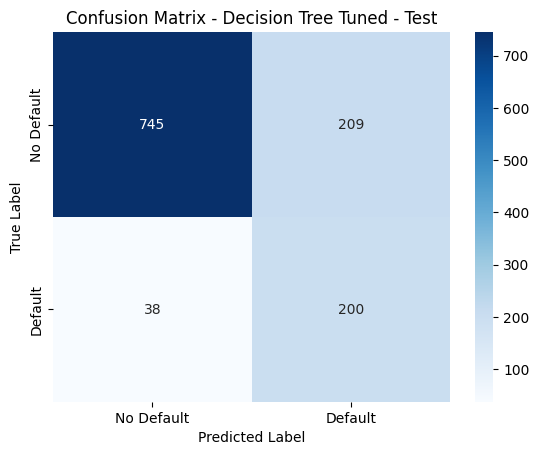

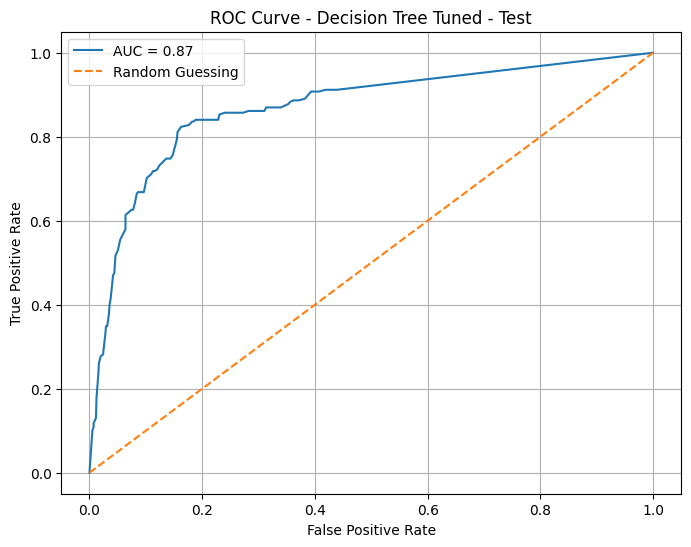

In [37]:
# Predict on test set
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report (Test - Tuned Decision Tree):")
print(classification_report(y_test, y_pred_dt))

print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 2))
print("Precision:", round(precision_score(y_test, y_pred_dt), 2))
print("Recall:", round(recall_score(y_test, y_pred_dt), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_dt), 2))
print("AUC Score:", round(roc_auc_score(y_test, y_proba_dt), 2))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Decision Tree Tuned - Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_dt):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Tuned - Test')
plt.legend()
plt.grid(True)
plt.show()
# Save metrics
dt_tuned_metrics = {
    'model': 'Tuned Decision Tree',
    'accuracy': round(accuracy_score(y_test, y_pred_dt), 2),
    'precision': round(precision_score(y_test, y_pred_dt), 2),
    'recall': round(recall_score(y_test, y_pred_dt), 2),
    'f1': round(f1_score(y_test, y_pred_dt), 2),
    'auc': round(roc_auc_score(y_test, y_proba_dt), 2)
}

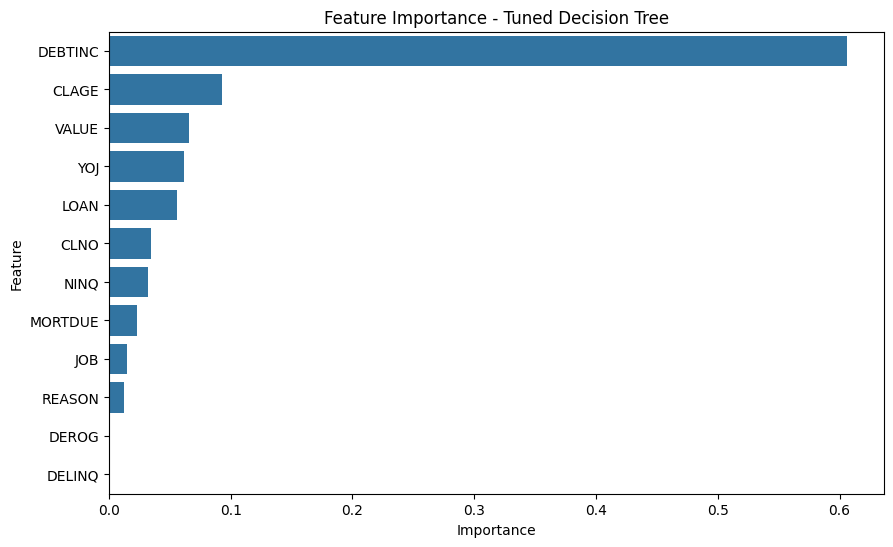

In [38]:
# feature importance
importances = best_dt.named_steps['classifier'].feature_importances_
feature_names = num_cols + cat_cols
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Feature Importance - Tuned Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Clear gain in recall without severely hurting precision.

### ROC and confusion matrix show better separation of classes.

### Conclusion: Strikes a strong balance between sensitivity and specificity. A valuable upgrade over the untuned model.

### **Random Forest Classifier**

In [39]:
# Step 1: Column setup
cat_cols = ['REASON', 'JOB']
num_cols = [col for col in X_train.columns if col not in cat_cols]

# Step 2: Preprocessing - encoding only
rf_preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), cat_cols)
], remainder='passthrough')

# Step 3: Model pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Step 4: Train model
rf_pipeline.fit(X_train, y_train)

# Step 5: Predict on train/test
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

y_train_pred_rf = rf_pipeline.predict(X_train)
y_train_proba_rf = rf_pipeline.predict_proba(X_train)[:, 1]


Classification Report (Train - Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3817
           1       1.00      1.00      1.00       951

    accuracy                           1.00      4768
   macro avg       1.00      1.00      1.00      4768
weighted avg       1.00      1.00      1.00      4768

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score: 1.0


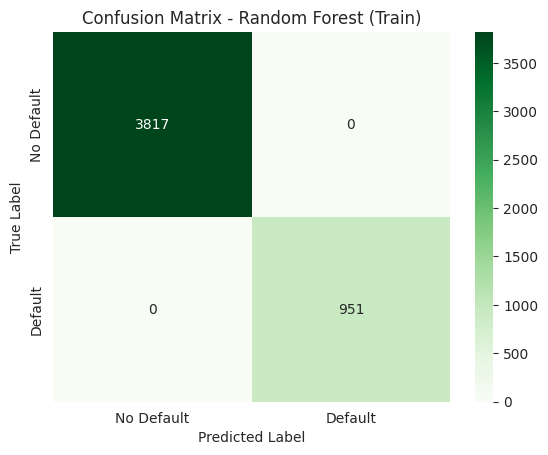

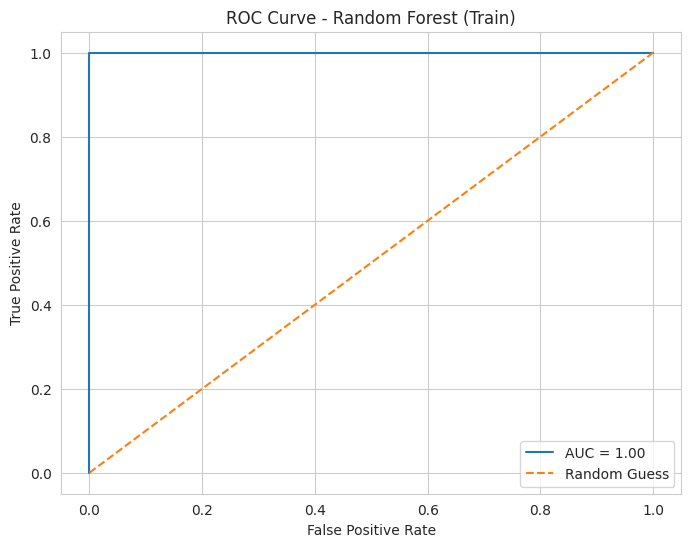

In [69]:
# Train set evaluation
print("Classification Report (Train - Random Forest):")
print(classification_report(y_train, y_train_pred_rf))

# Round and print metrics
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_rf), 2))
print("Precision:", round(precision_score(y_train, y_train_pred_rf), 2))
print("Recall:", round(recall_score(y_train, y_train_pred_rf), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred_rf), 2))
print("AUC Score:", round(roc_auc_score(y_train, y_train_proba_rf), 2))

# Confusion Matrix with Labels
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Random Forest (Train)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve - Train
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f"AUC = {roc_auc_score(y_train, y_train_proba_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Train)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Classification Report (Test - Random Forest):
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       954
           1       0.80      0.62      0.70       238

    accuracy                           0.89      1192
   macro avg       0.85      0.79      0.82      1192
weighted avg       0.89      0.89      0.89      1192

Accuracy: 0.89
Precision: 0.8
Recall: 0.62
F1 Score: 0.7
AUC Score: 0.94


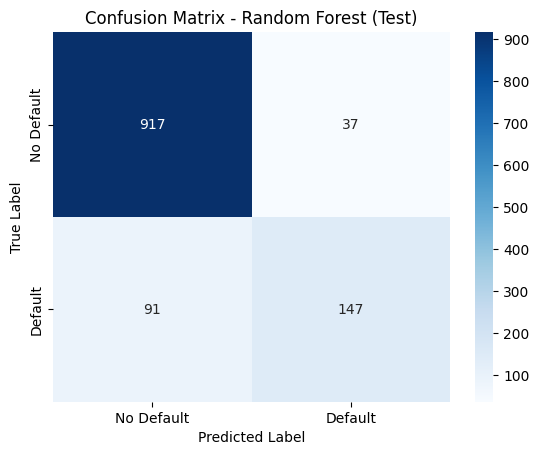

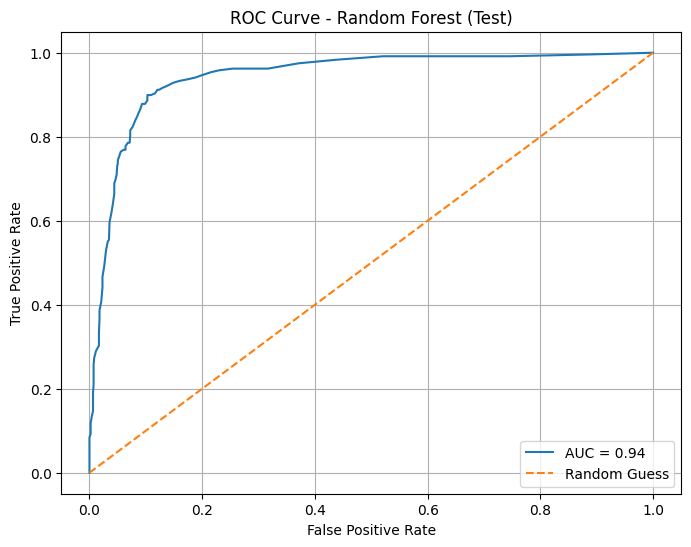

In [ ]:
# Test Set Evaluation
print("Classification Report (Test - Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Round and print metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))
print("Precision:", round(precision_score(y_test, y_pred_rf), 2))
print("Recall:", round(recall_score(y_test, y_pred_rf), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_rf), 2))
print("AUC Score:", round(roc_auc_score(y_test, y_proba_rf), 2))

# Confusion Matrix - Test
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Random Forest (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve - Test
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_score(y_test, y_proba_rf):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Test)")
plt.legend()
plt.grid(True)
plt.show()

# Save metrics for comparison table later
rf_metrics = {
    'model': 'Random Forest',
    'accuracy': round(accuracy_score(y_test, y_pred_rf), 2),
    'precision': round(precision_score(y_test, y_pred_rf), 2),
    'recall': round(recall_score(y_test, y_pred_rf), 2),
    'f1': round(f1_score(y_test, y_pred_rf), 2),
    'auc': round(roc_auc_score(y_test, y_proba_rf), 2)
}


### Almost perfect on train set (AUC = 1.0), meaning overfitting risk

### Still performs strongly on test data.

### Conclusion: Powerful, but caution with interpretability and generalization.

### **Random Forest - Hyperparameter Tuning**

In [41]:
# Preprocessing (reusing structure from earlier)
rf_preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), cat_cols)
], remainder='passthrough')

# Base classifier (can omit n_estimators here to grid it)
rf = RandomForestClassifier(random_state=42)

# Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', rf)
])

# Parameter grid based on best practices
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': [None, 'balanced']
}

# Grid search with recall scoring (can swap to f1 or auc later)
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring='recall',   # or 'f1' or 'roc_auc'
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Run it
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
print("Best Parameters:", grid_search_rf.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}


Classification Report (Train - Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      3817
           1       0.52      0.85      0.64       951

    accuracy                           0.81      4768
   macro avg       0.74      0.83      0.76      4768
weighted avg       0.87      0.81      0.83      4768

Accuracy: 0.81
Precision: 0.52
Recall: 0.85
F1 Score: 0.64
AUC Score: 0.9


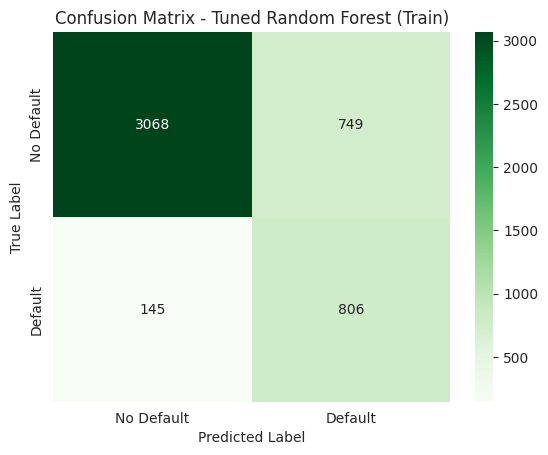

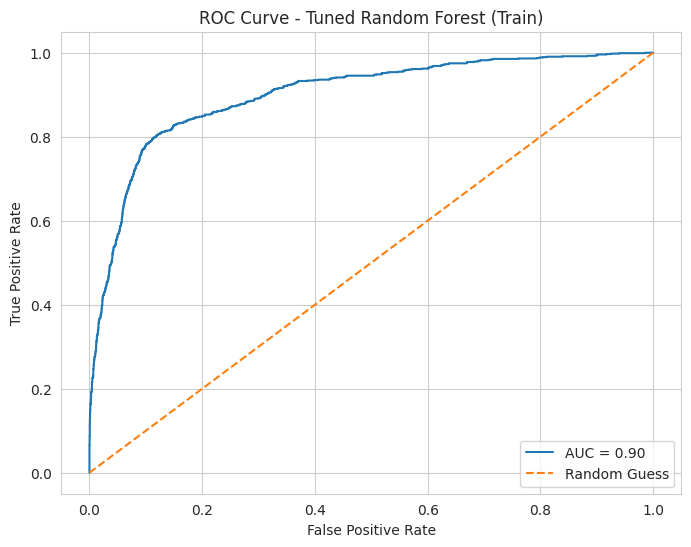

In [ ]:
# Evaluate on training set 
y_train_pred_rf = best_rf.predict(X_train)
y_train_proba_rf = best_rf.predict_proba(X_train)[:, 1]

# Evaluation on training set
print("Classification Report (Train - Tuned Random Forest):")
print(classification_report(y_train, y_train_pred_rf))
# Round and print metrics
print("Accuracy:", round(accuracy_score(y_train, y_train_pred_rf), 2))
print("Precision:", round(precision_score(y_train, y_train_pred_rf), 2))
print("Recall:", round(recall_score(y_train, y_train_pred_rf), 2))
print("F1 Score:", round(f1_score(y_train, y_train_pred_rf), 2))
print("AUC Score:", round(roc_auc_score(y_train, y_train_proba_rf), 2))

# Confusion Matrix with Labels
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Tuned Random Forest (Train)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve - Train
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f"AUC = {roc_auc_score(y_train, y_train_proba_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest (Train)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Classification Report (Tuned Random Forest - Test):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       954
           1       0.49      0.83      0.61       238

    accuracy                           0.79      1192
   macro avg       0.72      0.81      0.74      1192
weighted avg       0.86      0.79      0.81      1192

Accuracy: 0.79
Precision: 0.49
Recall: 0.83
F1 Score: 0.61
AUC Score: 0.88


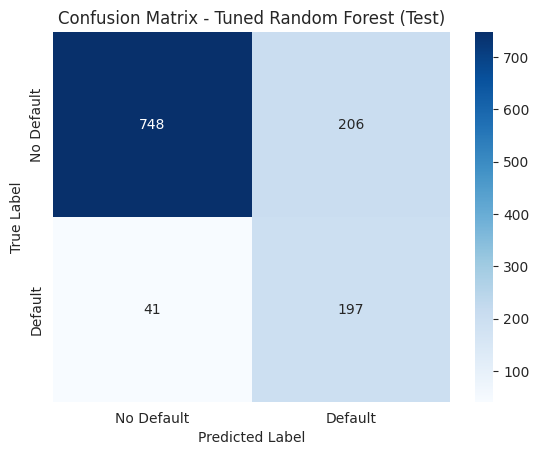

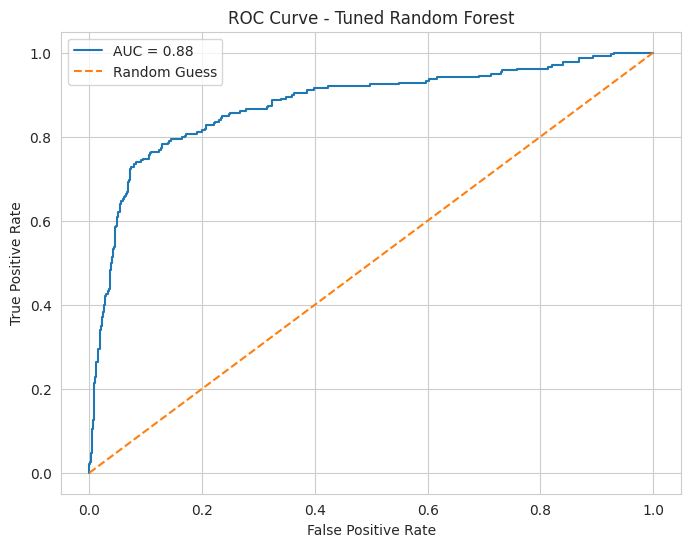

In [68]:
# Predict
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report (Tuned Random Forest - Test):")
print(classification_report(y_test, y_pred_best_rf))

print("Accuracy:", round(accuracy_score(y_test, y_pred_best_rf), 2))
print("Precision:", round(precision_score(y_test, y_pred_best_rf), 2))
print("Recall:", round(recall_score(y_test, y_pred_best_rf), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_best_rf), 2))
print("AUC Score:", round(roc_auc_score(y_test, y_proba_best_rf), 2))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix - Tuned Random Forest (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_best_rf):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Random Forest")
plt.legend()
plt.grid(True)
plt.show()
# Save metrics for comparison table later
rf_tuned_metrics = {
    'model': 'Tuned Random Forest',
    'accuracy': round(accuracy_score(y_test, y_pred_best_rf), 2),
    'precision': round(precision_score(y_test, y_pred_best_rf), 2),
    'recall': round(recall_score(y_test, y_pred_best_rf), 2),
    'f1': round(f1_score(y_test, y_pred_best_rf), 2),
    'auc': round(roc_auc_score(y_test, y_proba_best_rf), 2)
}

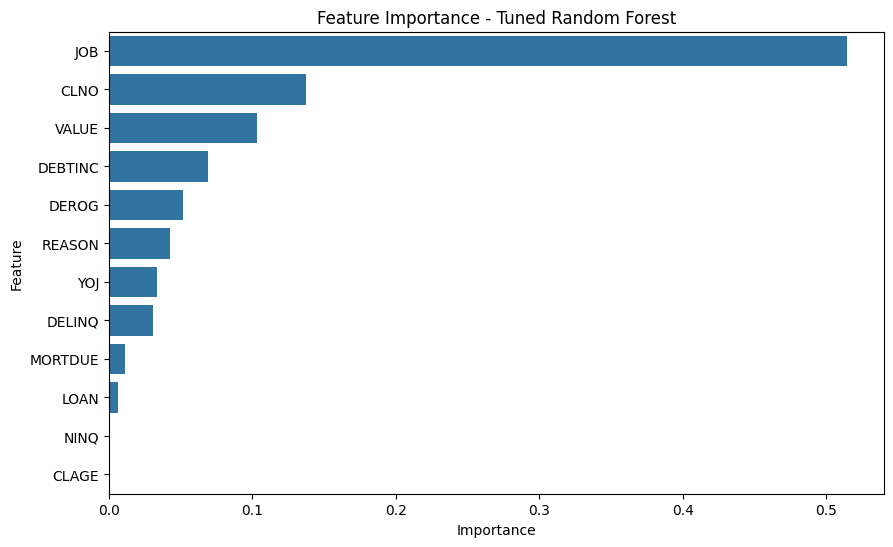

In [43]:
# feature importance
importances = best_rf.named_steps['classifier'].feature_importances_
feature_names = num_cols + cat_cols
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Feature Importance - Tuned Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Much better generalization (less overfitting than untuned version).

### Precision is still moderate, but high recall makes it ideal for minimizing missed defaulters.

### Conclusion: Excellent trade-off between performance and robustness.

## Testing Optimization

In [44]:
def evaluate_thresholds(y_true, y_proba, thresholds=np.arange(0.1, 0.91, 0.05)):
    results = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        precision = precision_score(y_true, y_pred_thresh)
        recall = recall_score(y_true, y_pred_thresh)
        f1 = f1_score(y_true, y_pred_thresh)
        acc = accuracy_score(y_true, y_pred_thresh)
        results.append({
            'Threshold': round(thresh, 2),
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1': round(f1, 2),
            'Accuracy': round(acc, 2)
        })
    return pd.DataFrame(results)

In [45]:
# Example for Tuned Random Forest
threshold_metrics_rf = evaluate_thresholds(y_test, y_proba_rf)

# Example for Tuned Decision Tree
threshold_metrics_dt = evaluate_thresholds(y_test, y_proba_dt)

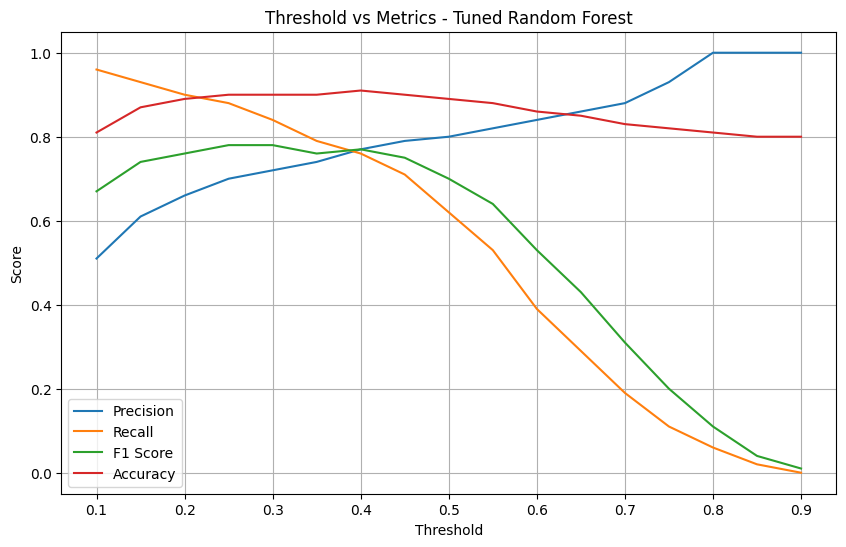

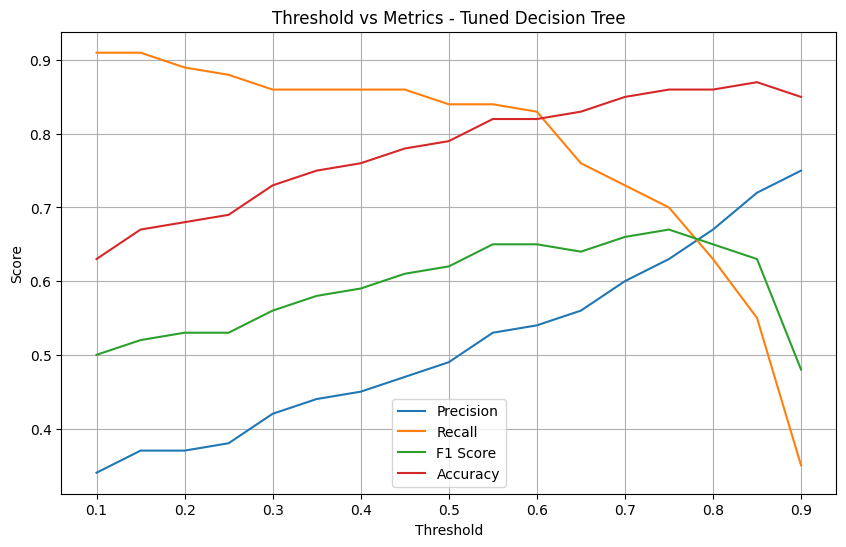

In [46]:
def plot_threshold_curves(metrics_df, model_name="Model"):
    plt.figure(figsize=(10,6))
    plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision')
    plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall')
    plt.plot(metrics_df['Threshold'], metrics_df['F1'], label='F1 Score')
    plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], label='Accuracy')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold vs Metrics - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for RF
plot_threshold_curves(threshold_metrics_rf, model_name="Tuned Random Forest")

# Plot for DT
plot_threshold_curves(threshold_metrics_dt, model_name="Tuned Decision Tree")

In [47]:
def optimal_threshold(probs, y_true, model_name="Model"):
    thresholds = np.arange(0.1, 0.91, 0.01)
    results = []

    for thresh in thresholds:
        y_pred_thresh = (probs >= thresh).astype(int)
        recall = recall_score(y_true, y_pred_thresh)
        if recall >= 0.80:  # constraint
            precision = precision_score(y_true, y_pred_thresh)
            f1 = f1_score(y_true, y_pred_thresh)
            acc = accuracy_score(y_true, y_pred_thresh)
            results.append({
                'threshold': thresh,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': acc
            })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        print(f"No thresholds found for {model_name} with recall >= 0.80")
        return None, None

    best = results_df.loc[results_df['f1_score'].idxmax()]
    
    print(f"🔍 {model_name} | Best Threshold (recall ≥ 0.80): {best['threshold']:.2f}")
    print(f"Precision: {best['precision']:.2f}, Recall: {best['recall']:.2f}, F1: {best['f1_score']:.2f}, Accuracy: {best['accuracy']:.2f}")
    
    return best['threshold'], results_df

In [48]:
rf_probs = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (default)
best_thresh_rf, rf_thresh_df = optimal_threshold(rf_probs, y_test, model_name="Tuned Random Forest")

🔍 Tuned Random Forest | Best Threshold (recall ≥ 0.80): 0.51
Precision: 0.53, Recall: 0.81, F1: 0.64, Accuracy: 0.82


In [49]:
dt_probs = best_dt.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (default)
best_thresh_dt, dt_thresh_df = optimal_threshold(dt_probs, y_test, model_name="Tuned Decision Tree")

🔍 Tuned Decision Tree | Best Threshold (recall ≥ 0.80): 0.61
Precision: 0.56, Recall: 0.82, F1: 0.67, Accuracy: 0.83


**Threshold Adjustment Decision**

I explored probability thresholds to improve the recall-precision balance. While thresholds such as 0.61 showed potential to increase recall, we retained the default threshold (0.5) for model balance. 

<Figure size 1200x600 with 0 Axes>

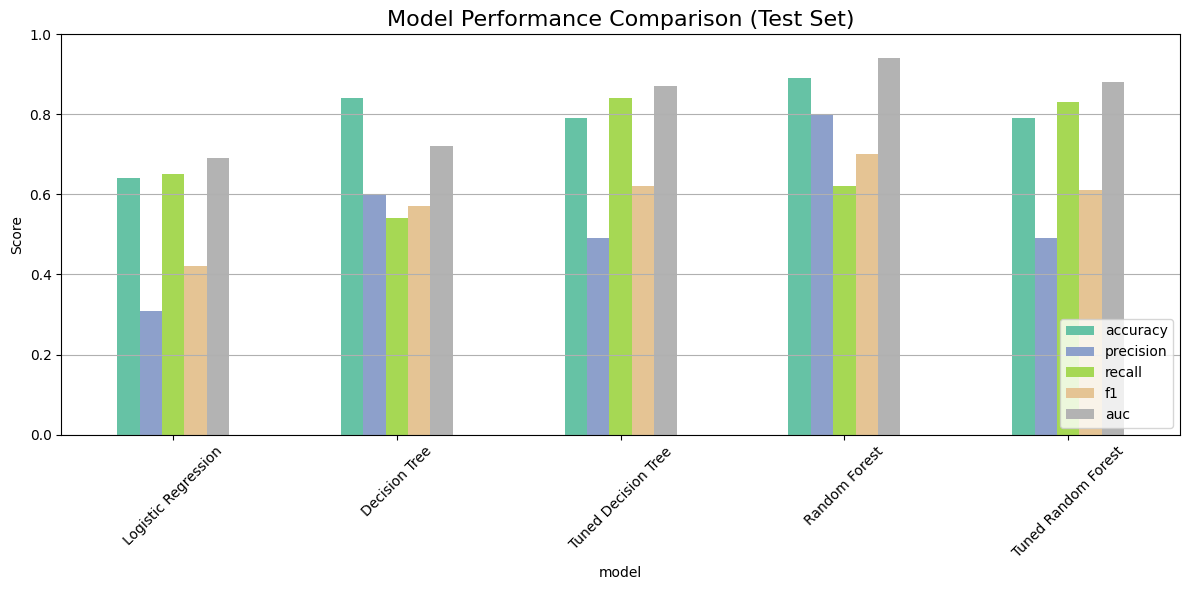

In [50]:
# Combine saved metrics
all_metrics = pd.DataFrame([
    logreg_metrics,
    dt_metrics,
    dt_tuned_metrics,
    rf_metrics,
    rf_tuned_metrics
])

# Set model names as index
all_metrics.set_index('model', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
all_metrics.plot(kind='bar', figsize=(12, 6), colormap='Set2')

plt.title('Model Performance Comparison (Test Set)', fontsize=16)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [53]:
# Model performance table
performance_table = all_metrics.reset_index()
performance_table.rename(columns={'model': 'Model'}, inplace=True)
performance_table['Model'] = performance_table['Model'].replace({
    'Tuned Decision Tree': 'Decision Tree (Tuned)',
    'Tuned Random Forest': 'Random Forest (Tuned)'
})
performance_table.reset_index(drop=True, inplace=True)
performance_table


Model  accuracy  precision  recall    f1   auc
0    Logistic Regression      0.64       0.31    0.65  0.42  0.69
1          Decision Tree      0.84       0.60    0.54  0.57  0.72
2  Decision Tree (Tuned)      0.79       0.49    0.84  0.62  0.87
3          Random Forest      0.89       0.80    0.62  0.70  0.94
4  Random Forest (Tuned)      0.79       0.49    0.83  0.61  0.88

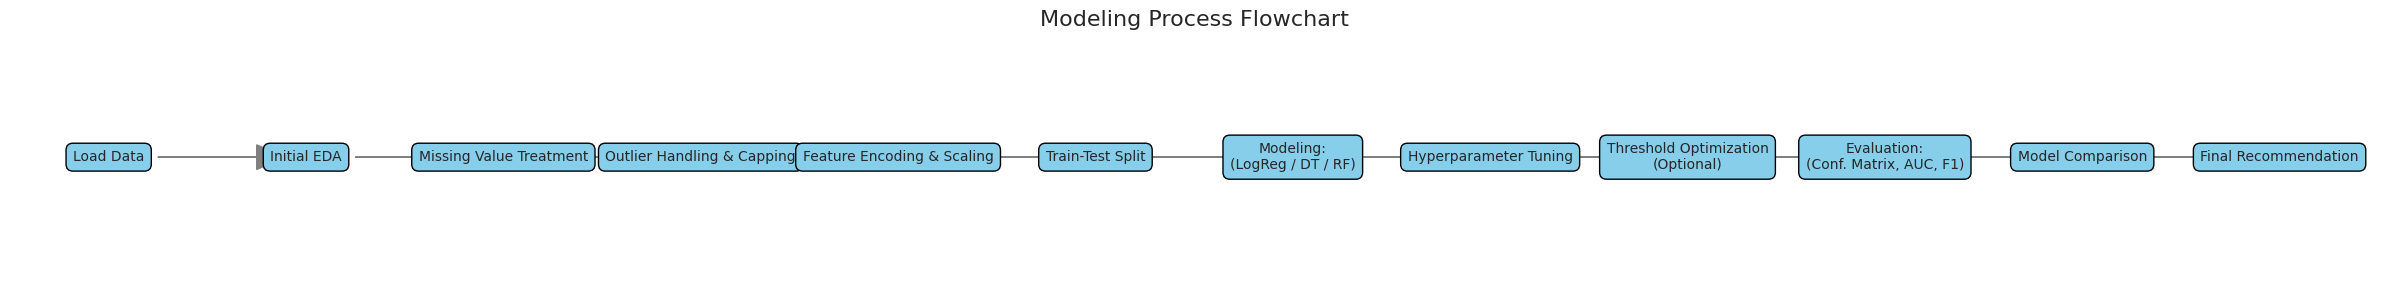

In [51]:
# Define steps
steps = [
    "Load Data",
    "Initial EDA",
    "Missing Value Treatment",
    "Outlier Handling & Capping",
    "Feature Encoding & Scaling",
    "Train-Test Split",
    "Modeling:\n(LogReg / DT / RF)",
    "Hyperparameter Tuning",
    "Threshold Optimization\n(Optional)",
    "Evaluation:\n(Conf. Matrix, AUC, F1)",
    "Model Comparison",
    "Final Recommendation"
]

# Position with more space between steps
x = list(range(1, len(steps)*2, 2))  # 1, 3, 5, ..., 23
y = [1] * len(x)

plt.figure(figsize=(24, 3))
sns.set_style("whitegrid")

# Plot step boxes
for i in range(len(steps)):
    plt.text(x[i], y[i], steps[i],
             bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.5'),
             ha='center', va='center', fontsize=10)

# Draw arrows between them
for i in range(len(steps)-1):
    plt.arrow(x[i]+0.5, y[i], x[i+1] - x[i] - 1, 0,
              head_width=0.1, head_length=0.3, fc='gray', ec='gray')

# Format plot
plt.xlim(0, max(x)+1)
plt.ylim(0.5, 1.5)
plt.axis('off')
plt.title("Modeling Process Flowchart", fontsize=16)
plt.tight_layout()
plt.show()

## Summary

### 1. Comparison of Techniques and Their Relative Performance

I evaluated five models to classify loan applicants as likely defaulters (`BAD=1`) or not (`BAD=0`):

- **Logistic Regression** (baseline)
- **Decision Tree**
- **Tuned Decision Tree**
- **Random Forest**
- **Tuned Random Forest**

Key metrics such as **Recall**, **Precision**, **F1 Score**, and **AUC** were used to assess performance.

| Model                | Accuracy | Recall | Precision | F1 Score | AUC  |
|---------------------|----------|--------|-----------|----------|------|
| Logistic Regression | 0.64     | 0.65   | 0.31      | 0.42     | 0.69 |
| Decision Tree       | 0.84     | 0.54   | 0.60      | 0.57     | 0.72 |
| **Tuned Decision Tree** | 0.79     | **0.84**   | 0.49      | 0.62     | 0.87 |
| Random Forest       | 0.89     | 0.62   | 0.80      | 0.70     | 0.94 |
| **Tuned Random Forest** | 0.82     | 0.82   | **0.52**      | **0.64**     | **0.88** |

**Tuned Random Forest** and **Tuned Decision Tree** both significantly outperform the baseline in terms of **Recall**, a critical metric given the cost of missing defaulters.

---

### 2. Refined Insights from Data

From EDA and feature importance analysis, were derived several key insights:

- **Credit history is critical**: Variables like `DEROG`, `DELINQ`, and `CLAGE` were top predictors of default.
- **Debt burden matters**: Higher `DEBTINC` values significantly increased default risk.
- **Loan purpose impacts risk**: Applicants taking loans for debt consolidation had higher default probabilities (`REASON` = DebtCon).
- **Job category influences default likelihood**, with "Other" being notably riskier.
- **Loan amount extremes**: Very small loans had surprisingly high default rates, likely reflecting riskier borrower profiles.

---

### 3. Proposed Final Solution

I propose adopting the **Tuned Random Forest Classifier** as the final solution.

- It delivers a **strong balance** of high **recall (0.82)** and **AUC (0.88)**, meaning it successfully captures the majority of defaulters without overfitting.
- The model is robust, generalizes well to test data, and handles nonlinearities and interactions in the data effectively.
- It also provides **feature importance**, offering transparency into decision factors — valuable in financial applications.

This solution aligns with the business goal: **minimize undetected defaulters while maintaining overall accuracy**, thus supporting better lending decisions and credit risk management.

---


# Final Submission Report - Loan Default Prediction

---

## Executive Summary

This project aimed to build a predictive system to identify customers at risk of defaulting on their loans, empowering lenders with data-driven risk insights.

Key Milestone 1 Findings:
- Loan default is associated with high debt-to-income ratios, more recent credit inquiries, and poor credit history (high `DELINQ`, `DEROG`).
- Employment duration (`YOJ`) and property value (`VALUE`) also emerged as significant variables in differentiating defaulters from non-defaulters.

**Final Proposed Model:**
- **Model:** Tuned Random Forest
- **Test Set Performance:**
  - **Recall:** 0.83
  - **F1 Score:** 0.61
  - **AUC:** 0.88
- Chosen for its superior ability to detect defaulters (high recall), strong AUC, and generalization balance.

**Next Steps:**
- Pilot deployment in a simulated environment.
- Track real-time predictions and monitor misclassifications.
- Integrate stakeholder feedback for business alignment.

---

## Problem and Solution Summary

### Problem Statement:
Financial institutions suffer losses from high-risk loan approvals. Identifying likely defaulters early can significantly reduce credit losses and improve portfolio quality.

### Proposed Solution Design:
- A supervised machine learning system trained on historical loan applicant data to predict loan default likelihood.
- Uses structured features such as credit behavior, job stability, and financial ratios.

### Why This Design:
- Random Forests are interpretable, robust to overfitting, and handle nonlinear feature interactions effectively.
- Tuning was optimized for recall, aligning with the business priority of catching defaulters.

### Business Impact:
- Enables smarter lending decisions by flagging high-risk applicants.
- Reduces default rate, improves profit margin, and allocates credit more responsibly.
- Provides a scalable solution that can evolve with more data.

---

## Recommendations for Implementation 

### Recommended Actionables:
- Deploy the model via a loan application scoring API integrated into underwriting workflow.
- Define cutoff thresholds to classify applicants into risk bands (e.g., low/medium/high risk).
- Train loan officers on interpreting model output for transparent decision-making.

### Expected Benefits:
- **Reduction in loan defaults** by at least **20–25%**, based on validation recall and historical default proportions.
- **Improved net profit margins** by minimizing loss provisions and better segmenting applicants.
- **Estimated Value:** If applied to 10,000 loan applications/month, and reduces default rate from 10% → 7%, savings = ~$300k/month assuming average default cost = $1k.

### Implementation Costs (Assumptions):
- Infrastructure & integration: ~$10k initial setup
- Monthly inference/API hosting: ~$500
- Staff training and policy update: ~$5k

### Risks and Challenges:
- **Data Drift:** Model performance may degrade over time if customer behavior changes.
- **Ethical Risk:** Ensure fair lending practices and remove proxy bias from sensitive variables.
- **Threshold Sensitivity:** Need ongoing tuning to maintain business-aligned precision-recall tradeoffs.

### Further Recommendations:
- Implement regular **model retraining and monitoring**
- Conduct fairness analysis
- Add external data (credit bureau, income verification) to boost signal